In [198]:
import pandas as pd

file_path = 'Northwind clean.xlsx' 

# טעינת כל הגליונות בבת אחת
# sheet_name=None יוצר מילון שבו המפתח הוא שם הגליון והערך הוא הדאטה-פריים
all_sheets = pd.read_excel(file_path, sheet_name=None)

# בדיקה: הדפסת שמות כל הטבלאות שנטענו
print("הטבלאות שנטענו:", all_sheets.keys())

# שליפת הטבלאות למשתנים נפרדים לנוחות העבודה
customers = all_sheets['Customers']
category = all_sheets['Category']
employees = all_sheets['Employees']
employee_territories = all_sheets['Employee Territories']
order_details = all_sheets['Order Details']
orders = all_sheets['Orders']
shippers = all_sheets['Shippers']
suppliers = all_sheets['Suppliers']
products = all_sheets['Products']
region = all_sheets['Region']
territorries = all_sheets['Territorries']

print(type(orders))

הטבלאות שנטענו: dict_keys(['Customers', 'Category', 'Employees', 'Employee Territories', 'Order Details', 'Orders', 'Shippers', 'Suppliers', 'Products', 'Region', 'Territorries'])
<class 'pandas.core.frame.DataFrame'>


הטבלאות הרלוונטיות אלי 

products -  ,לקבל את המוצרים, כמה הם עולים לחברה, מי הספק של כל מוצר,
 לאיזה קטוגריה שייך כל מוצר, כמה מוצרים יש במחסן, כמה מוצרים כבר הוזמנו מהספק,ומה הקו האדום של המוצרים (כלומר מזמינים עוד) ולראות איזה מוצר הופסק

orders - לראות איזה לקוח מזמין ומה, איזה עובד עזר לו, זמני הזמנה שליחה והגעה, 

order detail - ,איזה מוצר הוזמן, לראות כמה הוזמן מכל מוצר, כמה שילמו לחברה, ומה הייתה ההנחה



In [199]:

# 1. חיבור בסיסי: הזמנות + פרטי הזמנה
# זה נותן לנו את המידע על *מה* הוזמן ובאיזה תאריך
df_orders_orders_detail = pd.merge(orders, order_details, on='OrderID', how='inner')

# 2. חיבור קריטי: הוספת נתוני המוצר (כולל עלות הקנייה)
# שים לב לשימוש ב-suffixes: זה יבדיל בין מחיר המכירה לעלות הקנייה
df_o_od_p = pd.merge(df_orders_orders_detail, products, on='ProductID', how='left', suffixes=('_Sold', '_Cost'))

#ספירת השורות בכל דאטה-פריים כדי לראות שהטבלאות התחברו כמו שרציתי
# print(df_orders_orders_detail.count())
# print(order_details.count())
print(df_o_od_p.count())

OrderID            2155
CustomerID         2155
EmployeeID         2155
OrderDate          2155
RequiredDate       2155
ShippedDate        2082
ShipVia            2155
Freight            2155
ShipName           2155
ShipAddress        2155
ShipCity           2155
ShipRegion          856
ShipPostalCode     2100
ShipCountry        2155
ProductID          2155
UnitPrice_Sold     2155
Quantity           2155
Discount           2155
ProductName        2155
SupplierID         2155
CategoryID         2155
QuantityPerUnit    2155
UnitPrice_Cost     2155
UnitsInStock       2155
UnitsOnOrder       2155
ReorderLevel       2155
Discontinued       2155
dtype: int64


In [200]:
# יצירת עמודות מחושבות
# 1. סך מכירות לשורה (לפני עלות)
df_o_od_p['Sales'] = df_o_od_p['UnitPrice_Sold'] * df_o_od_p['Quantity'] * (1 - df_o_od_p['Discount'])

# 2. סך עלות לשורה
df_o_od_p['Total_Cost'] = df_o_od_p['UnitPrice_Cost'] * df_o_od_p['Quantity']

# 3. רווח גולמי (Profit)
df_o_od_p['Profit'] = df_o_od_p['Sales'] - df_o_od_p['Total_Cost']

# תצוגה מקדימה של התוצאה הסופית
print("\n--- דוגמה לנתונים המחושבים (5 שורות ראשונות) ---")
df_o_od_p[['OrderID', 'ProductName', 'Sales', 'Total_Cost', 'Profit']].head()


--- דוגמה לנתונים המחושבים (5 שורות ראשונות) ---


,OrderID,ProductName,Sales,Total_Cost,Profit
0,10248,Queso Cabrales,168.0,126.000,42.000
1,10248,Singaporean Hokkien Fried Mee,98.0,70.000,28.000
2,10248,Mozzarella di Giovanni,174.0,87.000,87.000
3,10249,Tofu,167.4,104.625,62.775
4,10249,Manjimup Dried Apples,1696.0,1060.000,636.000


In [201]:
#ייצוא הטבלה לאקסל כדי שאוכל לעבוד עליה בטבלאו
# df_o_od_p.to_excel('northwind_checked_data.xlsx', index=False)

In [202]:
# קיבוץ כל ההזמנות לפי OrderID וסכימת הרווח העלות המכירה וההנחה לכל הזמנה
order_aggregated = df_o_od_p.groupby('OrderID').agg({
    'Sales': 'sum', 
    'Total_Cost': 'sum', 
    'Profit': 'sum', 
    'Quantity': 'sum',
    'Discount': 'mean'
}).reset_index()
order_aggregated['count_OrderID'] = df_o_od_p.groupby('OrderID')['OrderID'].transform('count')
# 
print(order_aggregated.head())

   OrderID    Sales  Total_Cost    Profit  Quantity  Discount  count_OrderID
0    10248   440.00     283.000   157.000        27  0.000000              3
1    10249  1863.40    1164.625   698.775        49  0.000000              3
2    10250  1552.60    1133.625   418.975        60  0.100000              3
3    10251   654.06     419.750   234.310        41  0.033333              2
4    10252  3597.90    2331.250  1266.650       105  0.033333              2


In [203]:
# בדיקת קורולציה בין משתנים שונים
correlation_matrix = order_aggregated[['Sales', 'Total_Cost', 'Profit', 'Quantity', 'Discount','count_OrderID']].corr()
print("\n--- מטריצת קורלציה ---")
correlation_matrix



--- מטריצת קורלציה ---


,Sales,Total_Cost,Profit,Quantity,Discount,count_OrderID
Sales,1.000000,0.980649,0.967764,0.675529,0.053376,0.041901
Total_Cost,0.980649,1.000000,0.899730,0.683874,0.132319,0.035297
Profit,0.967764,0.899730,1.000000,0.626199,-0.051233,0.048003
Quantity,0.675529,0.683874,0.626199,1.000000,0.164712,0.031441
Discount,0.053376,0.132319,-0.051233,0.164712,1.000000,0.010883
count_OrderID,0.041901,0.035297,0.048003,0.031441,0.010883,1.000000


In [204]:
# # ייצוא לאקסל
# order_aggregated.to_excel('order_aggregated.xlsx', index=False)

מעבר לבדיקה על מוצרים

In [205]:
#בדיקה על איזה מוצרים מרוויחים הכי הרבה
product_performance = df_o_od_p.groupby('ProductName').agg({
    'Sales': 'sum',
    'Total_Cost': 'sum',
    'Profit': 'sum',
    'Quantity': 'sum',
    'Discount': 'mean'
}).reset_index()
print(product_performance.sort_values(by='Profit', ascending=False).head(10))


                ProductName       Sales  Total_Cost     Profit  Quantity  \
11            Cפte de Blaye  141396.735    82080.25  59316.485       623   
68  Thringer Rostbratwurst   80368.672    46173.67  34195.002       746   
51     Raclette Courdavault   71155.700    41140.00  30015.700      1496   
66           Tarte au sucre   47234.970    26695.95  20539.020      1083   
3         Camembert Pierrot   46825.480    26809.00  20016.480      1577   
17   Gnocchi di nonna Alice   42593.060    23997.00  18596.060      1263   
36    Manjimup Dried Apples   41819.650    23479.00  18340.650       886   
0              Alice Mutton   32698.380    19071.00  13627.380       978   
4          Carnarvon Tigers   29171.875    16843.75  12328.125       539   
56        Rצssle Sauerkraut   25696.640    14592.00  11104.640       640   

    Discount  
11  0.045833  
68  0.064062  
51  0.047222  
66  0.054167  
3   0.063922  
17  0.062000  
36  0.051282  
0   0.062162  
4   0.079630  
56  0.037879 

In [206]:
#בדיקת קורולציה בין משתנים שונים בטבלת המוצרים
correlation_matrix_products = product_performance[['Sales', 'Total_Cost', 'Profit', 'Quantity', 'Discount']].corr()
print("\n--- מטריצת קורלציה למוצרים ---")
print(correlation_matrix_products)


--- מטריצת קורלציה למוצרים ---
               Sales  Total_Cost    Profit  Quantity  Discount
Sales       1.000000    0.999682  0.999407  0.366862 -0.038866
Total_Cost  0.999682    1.000000  0.998221  0.365443 -0.026320
Profit      0.999407    0.998221  1.000000  0.368421 -0.055947
Quantity    0.366862    0.365443  0.368421  1.000000  0.054341
Discount   -0.038866   -0.026320 -0.055947  0.054341  1.000000


מסקנה ככל שיש לי יותר מוצרים לא אומר שאני מוכר יותר כלומר אני לא מרוויח אותו דבר על כל מוצר 
התמכור של המוצרים שלי לא שווה

In [207]:
# הוספת עמודות המציינות את הבינים של המוצר מבחינת רווחיות ונפח מכירות
product_performance['Sales_score']=product_performance['Sales'].rank(ascending=False)
product_performance['Profit_score']=product_performance['Profit'].rank(ascending=False)
product_performance['Quantity_score']=product_performance['Quantity'].rank(ascending=False)
product_performance['Total_Cost_score']=product_performance['Total_Cost'].rank(ascending=False)
product_performance.head()

,ProductName,Sales,Total_Cost,Profit,Quantity,Discount,Sales_score,Profit_score,Quantity_score,Total_Cost_score
0,Alice Mutton,32698.380,19071.00,13627.380,978,0.062162,8.0,8.0,15.0,8.0
1,Aniseed Syrup,3044.000,1640.00,1404.000,328,0.016667,71.0,70.0,63.0,71.0
2,Boston Crab Meat,17910.630,10147.60,7763.030,1103,0.051220,21.0,21.0,8.0,22.0
3,Camembert Pierrot,46825.480,26809.00,20016.480,1577,0.063922,5.0,5.0,1.0,4.0
4,Carnarvon Tigers,29171.875,16843.75,12328.125,539,0.079630,9.0,9.0,48.0,9.0


In [208]:
#חמשת המוצרים הכי נמכרים
print(product_performance.sort_values(by='Quantity', ascending=False).head(10))
print("\nמספר המוצרים השונים במערכת:")
print(product_performance['ProductName'].count())

               ProductName       Sales  Total_Cost      Profit  Quantity  \
3        Camembert Pierrot  46825.4800   26809.000  20016.4800      1577   
51    Raclette Courdavault  71155.7000   41140.000  30015.7000      1496   
18       Gorgonzola Telino  14920.8750    8731.250   6189.6250      1397   
17  Gnocchi di nonna Alice  42593.0600   23997.000  18596.0600      1263   
46                 Pavlova  17215.7755   10103.550   7112.2255      1158   
53    Rhצnbrהu Klosterbier   8177.4900    4475.625   3701.8650      1155   
21      Guaranב Fantבstica   4504.3650    2531.250   1973.1150      1125   
2         Boston Crab Meat  17910.6300   10147.600   7763.0300      1103   
66          Tarte au sucre  47234.9700   26695.950  20539.0200      1083   
14             Flotemysost  19551.0250   11362.750   8188.2750      1057   

    Discount  Sales_score  Profit_score  Quantity_score  Total_Cost_score  
3   0.063922          5.0           5.0             1.0               4.0  
51  0.04722

In [209]:
#המוצרים הכי רווחים
product_performance.sort_values(by='Profit_score', ascending=True).head(10)


,ProductName,Sales,Total_Cost,Profit,Quantity,Discount,Sales_score,Profit_score,Quantity_score,Total_Cost_score
11,Cפte de Blaye,141396.735,82080.25,59316.485,623,0.045833,1.0,1.0,41.0,1.0
68,Thringer Rostbratwurst,80368.672,46173.67,34195.002,746,0.064062,2.0,2.0,31.0,2.0
51,Raclette Courdavault,71155.700,41140.00,30015.700,1496,0.047222,3.0,3.0,2.0,3.0
66,Tarte au sucre,47234.970,26695.95,20539.020,1083,0.054167,4.0,4.0,9.0,5.0
3,Camembert Pierrot,46825.480,26809.00,20016.480,1577,0.063922,5.0,5.0,1.0,4.0
17,Gnocchi di nonna Alice,42593.060,23997.00,18596.060,1263,0.062000,6.0,6.0,4.0,6.0
36,Manjimup Dried Apples,41819.650,23479.00,18340.650,886,0.051282,7.0,7.0,18.0,7.0
0,Alice Mutton,32698.380,19071.00,13627.380,978,0.062162,8.0,8.0,15.0,8.0
4,Carnarvon Tigers,29171.875,16843.75,12328.125,539,0.079630,9.0,9.0,48.0,9.0
56,Rצssle Sauerkraut,25696.640,14592.00,11104.640,640,0.037879,10.0,10.0,40.0,10.0


In [210]:
#רשימה של המכירים שצריך למכור יותר מהם (לפי יחס רווח לכמות)
product_performance['Profit_per_Quantity'] = product_performance['Profit'] / product_performance['Quantity']
product_performance['Profit_per_Quantity_score'] = product_performance['Profit_per_Quantity'].rank(ascending=False)
underperforming_products = product_performance.sort_values(by='Quantity').head(10)
print("\n--- מוצרים עם יחס רווח לכמות נמוך ---")
underperforming_products



--- מוצרים עם יחס רווח לכמות נמוך ---


,ProductName,Sales,Total_Cost,Profit,Quantity,Discount,Sales_score,Profit_score,Quantity_score,Total_Cost_score,Profit_per_Quantity,Profit_per_Quantity_score
39,Mishi Kobe Niku,7226.5000,4607.500,2619.0000,95,0.100000,52.0,55.0,77.0,50.0,27.568421,4.0
16,Genen Shouyu,1784.8250,945.500,839.3250,122,0.016667,75.0,75.0,76.0,75.0,6.879713,43.0
20,Gravad lax,2688.4000,1625.000,1063.4000,125,0.050000,72.0,73.0,75.0,72.0,8.507200,30.0
10,Chocolade,1368.7125,879.750,488.9625,138,0.108333,77.0,77.0,74.0,77.0,3.543207,67.0
32,Laughing Lumberjack Lager,2396.8000,1288.000,1108.8000,184,0.060000,74.0,72.0,73.0,74.0,6.026087,51.0
73,Valkoinen suklaa,3437.6875,1909.375,1528.3125,235,0.025000,68.0,67.0,72.0,69.0,6.503457,46.0
35,Louisiana Hot Spiced Okra,3383.0000,2031.500,1351.5000,239,0.031250,69.0,71.0,71.0,68.0,5.654812,53.0
55,Rצd Kaviar,3997.2000,2197.500,1799.7000,293,0.047143,65.0,65.0,70.0,67.0,6.142321,49.0
33,Longlife Tofu,2432.5000,1485.000,947.5000,297,0.050000,73.0,74.0,68.5,73.0,3.190236,72.0
37,Mascarpone Fabioli,8404.1600,4752.000,3652.1600,297,0.073333,48.0,48.0,68.5,47.0,12.296835,23.0


In [211]:
# # ייצוא לאקסל
# product_performance.to_excel('product_performance.xlsx', index=False)

In [212]:
# 2. נגדיר מה זה "מוכר הכי הרבה" (High Volume)
# נחליט שזה מוצרים שנמצאים ב-25% העליונים מבחינת כמות מכירות
high_volume_threshold = product_performance['Quantity'].quantile(0.75)

# 3. נסנן: נשאיר רק את המוצרים שעברו את הרף הזה
popular_products = product_performance[product_performance['Quantity'] >= high_volume_threshold]

# 4. המהלך הסופי: נמיין את המוצרים הפופולריים האלו לפי הרווח (מהנמוך לגבוה)
# אלו שיהיו למעלה הם הבעייתיים - נמכרים המון, אבל מכניסים מעט
busy_work_products = popular_products.sort_values(by='Profit', ascending=True)

print(f"סף הכמות לכניסה לרשימה: {high_volume_threshold} יחידות")
print("\n---  (ליחידה)המוצרים ברבעון העליון של הנמכרים ביותר עם הרווח הנמוך ביותר ---")
busy_work_products.head(10)

סף הכמות לכניסה לרשימה: 828.0 יחידות

---  (ליחידה)המוצרים ברבעון העליון של הנמכרים ביותר עם הרווח הנמוך ביותר ---


,ProductName,Sales,Total_Cost,Profit,Quantity,Discount,Sales_score,Profit_score,Quantity_score,Total_Cost_score,Profit_per_Quantity,Profit_per_Quantity_score
21,Guaranב Fantבstica,4504.365,2531.250,1973.115,1125,0.056863,63.0,62.0,7.0,63.0,1.753880,76.0
30,Konbu,4960.440,2673.000,2287.440,891,0.042500,60.0,59.0,17.0,61.0,2.567273,74.0
53,Rhצnbrהu Klosterbier,8177.490,4475.625,3701.865,1155,0.052174,49.0,46.0,6.0,51.0,3.205078,71.0
29,Jack's New England Clam Chowder,8680.345,4733.325,3947.020,981,0.040426,45.0,44.0,13.5,48.0,4.023466,64.0
62,Sir Rodney's Scones,9104.000,5080.000,4024.000,1016,0.056410,43.0,43.0,12.0,43.0,3.960630,65.0
5,Chai,12788.100,7452.000,5336.100,828,0.077632,35.0,36.0,20.0,34.0,6.444565,48.0
65,Steeleye Stout,13644.000,7947.000,5697.000,883,0.047222,31.0,33.0,19.0,30.0,6.451869,47.0
18,Gorgonzola Telino,14920.875,8731.250,6189.625,1397,0.062745,28.0,28.0,3.0,27.0,4.430655,61.0
6,Chang,16355.960,10041.500,6314.460,1057,0.102273,25.0,27.0,10.5,24.0,5.973945,52.0
48,Pגtי chinois,17426.400,10836.000,6590.400,903,0.077273,22.0,26.0,16.0,21.0,7.298339,38.0


מהמוצרים למעלה כדאי לחשוב על לעלות את המחיר כי הם נמכרים הרבה אבל אנחנו לא מרוויחים עליהם כמעט כלום

מעבר לבדיקת העובדים

In [213]:
#בדיקה מי העובד שמרוויח לחברה הכי הרבה
employee_performance = df_o_od_p.groupby('EmployeeID').agg({
    'Sales': 'sum',
    'Total_Cost': 'sum',
    'Profit': 'sum',
    'Quantity': 'sum',
    'Discount': 'mean'
}).reset_index()
employee_performance['Discount_score']=employee_performance['Discount'].rank(ascending=True)
employee_performance['Sales_score']=employee_performance['Sales'].rank(ascending=False)
employee_performance['Profit_score']=employee_performance['Profit'].rank(ascending=False)
print(employee_performance.sort_values(by='Profit', ascending=False).head(10))
print("\nמספר העובדים השונים במערכת:")
print(employee_performance['EmployeeID'].count())

   EmployeeID        Sales  Total_Cost      Profit  Quantity  Discount  \
3           4  232890.8460  137554.990  95335.8560      9798  0.061310   
2           3  202812.8430  112802.735  90010.1080      7852  0.049688   
0           1  192107.6045  107858.895  84248.7095      7812  0.049246   
1           2  166537.7550   92697.560  73840.1950      6055  0.043776   
7           8  126862.2775   71975.430  54886.8475      5913  0.056154   
6           7  124568.2350   75801.095  48767.1400      4654  0.073580   
8           9   77308.0665   43283.300  34024.7665      2670  0.068224   
5           6   73913.1295   41836.725  32076.4045      3527  0.054464   
4           5   68792.2825   40872.925  27919.3575      3036  0.066667   

   Discount_score  Sales_score  Profit_score  
3             6.0          1.0           1.0  
2             3.0          2.0           2.0  
0             2.0          3.0           3.0  
1             1.0          4.0           4.0  
7             5.0       

In [214]:
# employee_performance.to_excel('employee_performance.xlsx', index=False)

כדאי לשאול את עובדת מספר 4 ושכולם ילמדו ממנה למכור יותר

נעבור לבדוק את המחסן

In [215]:
#הכנת נתוני מלאי ומכירות לטבלה אחת
inventory_sales = pd.merge(products[['ProductName', 'UnitsInStock','UnitsOnOrder','ReorderLevel','Discontinued']], 
                           product_performance, 
                           on='ProductName', how='left')
print(inventory_sales.columns)
print(inventory_sales.count())

Index(['ProductName', 'UnitsInStock', 'UnitsOnOrder', 'ReorderLevel',
       'Discontinued', 'Sales', 'Total_Cost', 'Profit', 'Quantity', 'Discount',
       'Sales_score', 'Profit_score', 'Quantity_score', 'Total_Cost_score',
       'Profit_per_Quantity', 'Profit_per_Quantity_score'],
      dtype='object')
ProductName                  77
UnitsInStock                 77
UnitsOnOrder                 77
ReorderLevel                 77
Discontinued                 77
Sales                        77
Total_Cost                   77
Profit                       77
Quantity                     77
Discount                     77
Sales_score                  77
Profit_score                 77
Quantity_score               77
Total_Cost_score             77
Profit_per_Quantity          77
Profit_per_Quantity_score    77
dtype: int64


In [216]:
# # ייצוא לאקסל 
# inventory_sales.to_excel('inventory_sales.xlsx', index=False)

In [217]:
#בדיקת קורולציה בין משתנים שונים בטבלת המוצרים
correlation_matrix_inventory = inventory_sales[['UnitsInStock','UnitsOnOrder','ReorderLevel','Sales', 'Total_Cost', 'Profit', 'Quantity', 'Discount']].corr()
print("\n--- מטריצת קורלציה למלאי ומכירות ---")
correlation_matrix_inventory


--- מטריצת קורלציה למלאי ומכירות ---


,UnitsInStock,UnitsOnOrder,ReorderLevel,Sales,Total_Cost,Profit,Quantity,Discount
UnitsInStock,1.000000,-0.369419,0.231562,-0.165285,-0.166100,-0.164004,-0.013414,-0.042264
UnitsOnOrder,-0.369419,1.000000,0.362830,-0.160148,-0.158246,-0.162579,-0.132639,0.000433
ReorderLevel,0.231562,0.362830,1.000000,-0.169950,-0.170140,-0.169516,-0.092574,-0.047228
Sales,-0.165285,-0.160148,-0.169950,1.000000,0.999682,0.999407,0.366862,-0.038866
Total_Cost,-0.166100,-0.158246,-0.170140,0.999682,1.000000,0.998221,0.365443,-0.026320
Profit,-0.164004,-0.162579,-0.169516,0.999407,0.998221,1.000000,0.368421,-0.055947
Quantity,-0.013414,-0.132639,-0.092574,0.366862,0.365443,0.368421,1.000000,0.054341
Discount,-0.042264,0.000433,-0.047228,-0.038866,-0.026320,-0.055947,0.054341,1.000000


In [218]:
#בדיקת ממוצע הזמנות מכל מוצר והשוואה למלאי הקיים
# 1. הכנת הנתונים: המרת תאריך לפורמט שאפשר לעשות עליו חישובים
df_o_od_p['OrderDate'] = pd.to_datetime(df_o_od_p['OrderDate'])

# 2. חישוב נתונים לכל מוצר: מתי התחיל להימכר, מתי סיים, וכמה מכר סה"כ
sales_velocity = df_o_od_p.groupby('ProductID').agg({
    'ProductName': 'first',         # השם
    'Quantity': 'sum',              # סך כל המכירות
    'OrderDate': ['min', 'max'],    # תאריך ראשון ואחרון
    'UnitsInStock': 'first'         # המלאי הנוכחי
}).reset_index()

# סידור שמות העמודות (כי agg יוצר שמות כפולים)
sales_velocity.columns = ['ProductID', 'ProductName', 'Total_Sold', 'First_Sale', 'Last_Sale', 'Current_Stock']

# 3. חישוב "תקופת הפעילות" בחודשים
# אנחנו מוסיפים 1 כדי למנוע חלוקה ב-0 וכדי להחשיב את החודש הנוכחי
import numpy as np
sales_velocity['Months_Active'] = ((sales_velocity['Last_Sale'] - sales_velocity['First_Sale']) / np.timedelta64(1, 'm')) + 1

# 4. חישוב קצב מכירה חודשי (Monthly Run Rate)
# זה הממוצע שחיפשת!
sales_velocity['Avg_Monthly_Sales'] = sales_velocity['Total_Sold'] / sales_velocity['Months_Active']

# 5. המדד החשוב ביותר: "חודשי מלאי" (Months of Supply)
# השאלה: "אם נפסיק להזמין היום, עוד כמה חודשים המחסן יתרוקן?"
sales_velocity['Months_Until_Empty'] = sales_velocity['Current_Stock'] / sales_velocity['Avg_Monthly_Sales']

# מיון: בוא נראה מי המוצרים ש"נתקענו" איתם להכי הרבה זמן
stuck_inventory = sales_velocity[sales_velocity['Current_Stock'] > 0].sort_values(by='Months_Until_Empty', ascending=False)

print("--- ניתוח מלאי חכם: לכמה חודשים יספיק המלאי הקיים? ---")
stuck_inventory[['ProductName', 'Current_Stock', 'Avg_Monthly_Sales', 'Months_Until_Empty']].head(10)

--- ניתוח מלאי חכם: לכמה חודשים יספיק המלאי הקיים? ---


,ProductName,Current_Stock,Avg_Monthly_Sales,Months_Until_Empty
5,Grandma's Boysenberry Spread,120,0.000352,341007.707641
72,Rצd Kaviar,101,0.000322,313713.928328
21,Gustaf's Knהckebrצd,104,0.000379,274129.954023
66,Laughing Lumberjack Lager,52,0.000207,251092.456522
11,Queso Manchego La Pastora,86,0.000368,233640.250000
49,Valkoinen suklaa,65,0.000302,215081.127660
24,NuNuCa Nu-Nougat-Creme,76,0.000389,195477.974843
33,Sasquatch Ale,111,0.000570,194903.934783
14,Genen Shouyu,39,0.000221,176766.221311
8,Mishi Kobe Niku,29,0.000180,161325.778947


In [219]:
# טבלה שמחשבת את הכמות הממוצעת שהוזמנה מכל מוצר לכל הזמנה
average_order_quantity = df_o_od_p.groupby('ProductName').agg({
    'Quantity':['mean', 'median', 'std'],
    'OrderID': 'nunique'  # מספר הזמנות ייחודיות למוצר
}).reset_index()
average_order_quantity.columns = ['ProductName', 'Avg_Qty', 'Median_Qty', 'Std_Qty', 'Order_Count']
# (יש פעם אחת או שניים שהזמינו מלא יותר מהממוצע) אם המספר הזה גדול מ-1, זה אומר שהממוצע "משקר" וההזמנות מאוד לא יציבות
average_order_quantity['Volatility'] = average_order_quantity['Std_Qty'] / average_order_quantity['Avg_Qty']
average_order_quantity['bad_volatility'] = average_order_quantity['Volatility'] > 1
print(average_order_quantity['bad_volatility'].value_counts())
average_order_quantity



bad_volatility
False    70
True      7
Name: count, dtype: int64


,ProductName,Avg_Qty,Median_Qty,Std_Qty,Order_Count,Volatility,bad_volatility
0,Alice Mutton,26.432432,20.0,21.447016,37,0.811390,False
1,Aniseed Syrup,27.333333,22.5,17.603374,12,0.644026,False
2,Boston Crab Meat,26.902439,20.0,21.981589,41,0.817085,False
3,Camembert Pierrot,30.921569,24.0,23.077992,51,0.746340,False
4,Carnarvon Tigers,19.962963,20.0,12.144899,27,0.608372,False
...,...,...,...,...,...,...,...
72,Uncle Bob's Organic Dried Pears,26.310345,20.0,21.998545,29,0.836118,False
73,Valkoinen suklaa,23.500000,23.0,10.102255,10,0.429883,False
74,Vegie-spread,26.176471,20.0,20.779302,17,0.793816,False
75,Wimmers gute Semmelknצdel,24.666667,22.0,23.870821,30,0.967736,False


In [220]:
# הצגת כל המוצרים עם סטיית תקן גבוהה מהממוצע
print("\n--- מוצרים עם סטיית תקן גבוהה מהממוצע ---")
print(average_order_quantity[average_order_quantity['bad_volatility']])



--- מוצרים עם סטיית תקן גבוהה מהממוצע ---
         ProductName    Avg_Qty  Median_Qty    Std_Qty  Order_Count  \
7   Chartreuse verte  26.433333        20.0  27.392024           30   
10         Chocolade  23.000000        15.0  23.883048            6   
20        Gravad lax  20.833333        14.0  21.301800            6   
30             Konbu  22.275000        12.5  22.802370           40   
47     Perth Pasties  24.066667        16.5  25.110697           30   
48      Pגtי chinois  27.363636        20.0  29.276503           33   
63    Sirop d'יrable  25.125000        18.0  28.306264           24   

    Volatility  bad_volatility  
7     1.036268            True  
10    1.038393            True  
20    1.022486            True  
30    1.023675            True  
47    1.043381            True  
48    1.069905            True  
63    1.126617            True  


נראה שיש ממש קצת עם שונות גבוהה וגם הם לא יותר מידי מרמים את הממוצע שלהם ככה שאפשר להסתמך עליו

In [221]:
# בדיקה כל כמה זמן יש הזמנה חדשה מכל מוצר
order_frequency = df_o_od_p.groupby('ProductName').agg({
    'OrderDate': ['min', 'max'],
    'OrderID': 'nunique'
}).reset_index()
order_frequency[('OrderDate', 'min')] = pd.to_datetime(order_frequency[('OrderDate', 'min')])
order_frequency[('OrderDate', 'max')] = pd.to_datetime(order_frequency[('OrderDate', 'max')])
order_frequency['Days_Active'] = (order_frequency[('OrderDate', 'max')] - order_frequency[('OrderDate', 'min')]).dt.days + 1
order_frequency['Avg_Days_Between_Orders'] = order_frequency['Days_Active'] / order_frequency[('OrderID', 'nunique')]
#adding Avg quantity perorder for every year
order_frequency

ProductName  OrderDate            OrderID Days_Active  \
                                           min        max nunique               
0                      Alice Mutton 1996-07-25 1998-05-01      37         646   
1                     Aniseed Syrup 1996-08-26 1998-05-06      12         619   
2                  Boston Crab Meat 1996-07-29 1998-04-30      41         641   
3                 Camembert Pierrot 1996-07-09 1998-05-06      51         667   
4                  Carnarvon Tigers 1996-08-29 1998-04-27      27         607   
..                              ...        ...        ...     ...         ...   
72  Uncle Bob's Organic Dried Pears 1996-07-22 1998-05-06      29         654   
73                 Valkoinen suklaa 1996-11-11 1998-05-05      10         541   
74                     Vegie-spread 1996-08-12 1998-04-22      17         619   
75        Wimmers gute Semmelknצdel 1996-08-26 1998-05-06      30         619   
76                    Zaanse koeken 1996-10-17 1998-03-26      21         526   

   Avg_Days_Between_Orders  
                            
0                17.459459  
1                51.583333  
2                15.634146  
3                13.078431  
4                22.481481  
..                     ...  
72               22.551724  
73               54.100000  
74               36.411765  
75               20.633333  
76               25.047619  

[77 rows x 6 columns]

In [222]:
# שילוב שני הטבלאות הללו לתוך טבלה אחת
# flatten the MultiIndex columns in order_frequency
order_frequency.columns = ['_'.join(col).strip('_') for col in order_frequency.columns.values]
product_order_insights = pd.merge(average_order_quantity, order_frequency, on='ProductName', how='left')
product_order_insights.head()

,ProductName,Avg_Qty,Median_Qty,Std_Qty,Order_Count,Volatility,bad_volatility,OrderDate_min,OrderDate_max,OrderID_nunique,Days_Active,Avg_Days_Between_Orders
0,Alice Mutton,26.432432,20.0,21.447016,37,0.811390,False,1996-07-25,1998-05-01,37,646,17.459459
1,Aniseed Syrup,27.333333,22.5,17.603374,12,0.644026,False,1996-08-26,1998-05-06,12,619,51.583333
2,Boston Crab Meat,26.902439,20.0,21.981589,41,0.817085,False,1996-07-29,1998-04-30,41,641,15.634146
3,Camembert Pierrot,30.921569,24.0,23.077992,51,0.746340,False,1996-07-09,1998-05-06,51,667,13.078431
4,Carnarvon Tigers,19.962963,20.0,12.144899,27,0.608372,False,1996-08-29,1998-04-27,27,607,22.481481


In [223]:
# חישוב כמה יחידות מכל מוצר נצטרך לשמור כדי לענות על הביקוש הממוצע במשך שנה
product_order_insights['Units_Needed_Per_Year'] = (365 / product_order_insights['Avg_Days_Between_Orders']) * product_order_insights['Avg_Qty']
# print(product_order_insights[['ProductName', 'Units_Needed_Per_Year']].head())
# חישוב כמה יחידות מכל מוצר נצטרך לשמור כדי לענות על הביקוש הממוצע במשך חודש
product_order_insights['Units_Needed_Per_Month'] = (30 / product_order_insights['Avg_Days_Between_Orders']) * product_order_insights['Avg_Qty']
# print(product_order_insights[['ProductName', 'Units_Needed_Per_Month']].head())
product_order_insights.head()

,ProductName,Avg_Qty,Median_Qty,Std_Qty,Order_Count,Volatility,bad_volatility,OrderDate_min,OrderDate_max,OrderID_nunique,Days_Active,Avg_Days_Between_Orders,Units_Needed_Per_Year,Units_Needed_Per_Month
0,Alice Mutton,26.432432,20.0,21.447016,37,0.811390,False,1996-07-25,1998-05-01,37,646,17.459459,552.585139,45.417957
1,Aniseed Syrup,27.333333,22.5,17.603374,12,0.644026,False,1996-08-26,1998-05-06,12,619,51.583333,193.408724,15.896607
2,Boston Crab Meat,26.902439,20.0,21.981589,41,0.817085,False,1996-07-29,1998-04-30,41,641,15.634146,628.073323,51.622465
3,Camembert Pierrot,30.921569,24.0,23.077992,51,0.746340,False,1996-07-09,1998-05-06,51,667,13.078431,862.976012,70.929535
4,Carnarvon Tigers,19.962963,20.0,12.144899,27,0.608372,False,1996-08-29,1998-04-27,27,607,22.481481,324.110379,26.639209


In [224]:
# בדיקה האם מה שיש לנו בסטוק מספיק כדי לענות על הביקוש הממוצע החודשי
inventory_demand = pd.merge(products[['ProductName', 'UnitsInStock']], product_order_insights[['ProductName', 'Units_Needed_Per_Month','Units_Needed_Per_Year']], on='ProductName')
inventory_demand['Stock_vs_Demand_Ratio_per_month'] = inventory_demand['UnitsInStock'] / inventory_demand['Units_Needed_Per_Month']
# בדיקה האם מה שיש לנו בסטוק מספיק כדי לענות על הביקוש הממוצע השנתי
inventory_demand['Stock_vs_Demand_Ratio_per_year'] = inventory_demand['UnitsInStock'] / inventory_demand['Units_Needed_Per_Year']
# הוספת עמודה שאם הצורך גדול מהמלאי יש להזהיר
inventory_demand['Reorder_Needed_monthly'] = inventory_demand['Stock_vs_Demand_Ratio_per_month'] < 1
inventory_demand['Reorder_Needed_yearly'] = inventory_demand['Stock_vs_Demand_Ratio_per_year'] < 1
print("\n--- בדיקת מלאי מול ביקוש חודשי ---")
print(inventory_demand['Reorder_Needed_monthly'].value_counts())
print("\n--- בדיקת מלאי מול ביקוש שנתי ---")
print(inventory_demand['Reorder_Needed_yearly'].value_counts())


--- בדיקת מלאי מול ביקוש חודשי ---
Reorder_Needed_monthly
True     42
False    35
Name: count, dtype: int64

--- בדיקת מלאי מול ביקוש שנתי ---
Reorder_Needed_yearly
True    77
Name: count, dtype: int64


In [225]:
# # ייצוא לאקסל 
# inventory_demand.to_excel('inventory_demand.xlsx', index=False)

ניהול המלאי בצורה חודשית צריך להתנהל יותר טוב וככה לא יהיו לנו יחידות שסתם יושבות במחסן

האם כשמוצר מגיע יותר מהר קונים ממנו יותר

In [226]:
# בדיקת מהירות ההגעה של כל הזמנה ללקוח
orders['OrderDate'] = pd.to_datetime(orders['OrderDate'])
orders['RequiredDate'] = pd.to_datetime(orders['RequiredDate'])
orders['ShippedDate'] = pd.to_datetime(orders['ShippedDate'])
orders['Days_to_Ship'] = (orders['ShippedDate'] - orders['OrderDate']).dt.days
orders['Days_to_Required'] = (orders['RequiredDate'] - orders['OrderDate']).dt.days
# הוספת עמודה שמייצרת ניקוד על סמך מהירות המשלוח
orders['Shipping_Score'] = orders['Days_to_Ship'].rank(ascending=True)
print(orders[['OrderID', 'Days_to_Ship', 'Days_to_Required', 'Shipping_Score']].sort_values(by='Days_to_Ship', ascending=False))
# הוספת עמודה שמציינת האם ההזמנה הגיעה בזמן או מאוחר
orders['On_Time'] = orders['ShippedDate'] <= orders['RequiredDate']
print("\n--- בדיקת הגעת הזמנות בזמן ---")
print(orders['On_Time'].value_counts())

     OrderID  Days_to_Ship  Days_to_Required  Shipping_Score
529    10777          37.0                14           808.5
412    10660          37.0                28           808.5
345    10593          35.0                28           805.0
676    10924          35.0                28           805.0
132    10380          35.0                28           805.0
..       ...           ...               ...             ...
825    11073           NaN                28             NaN
826    11074           NaN                28             NaN
827    11075           NaN                28             NaN
828    11076           NaN                28             NaN
829    11077           NaN                28             NaN

[830 rows x 4 columns]

--- בדיקת הגעת הזמנות בזמן ---
On_Time
True     772
False     58
Name: count, dtype: int64


In [227]:
# בדיקת לקוחות לעומת זמני משלוח (האם יש קשר בין כמות קניית הלקוח למהירות המשלוח?)
customer_shipping = pd.merge(orders[['OrderID', 'CustomerID', 'Days_to_Ship','Days_to_Required', 'On_Time','Shipping_Score']], 
                              order_aggregated[['OrderID', 'Sales', 'Quantity', 'Profit']], 
                              on='OrderID', how='left')
print(customer_shipping.head())
print("\n--- קורלציה בין כמות קנייה למהירות משלוח ---")
print(customer_shipping[['Days_to_Ship', 'Sales', 'Quantity', 'Profit']].corr())



# customer_shipping.groupby('CustomerID').agg({
#     'Days_to_Ship': 'mean',
#     'Days_to_Required': 'mean',
#     'On_Time': 'mean',
#     'Shipping_Score': 'mean',
#     'Sales': 'sum',
#     'Quantity': 'sum',
#     'Profit': 'sum'
# }).reset_index().sort_values(by='Sales', ascending=True).head(10)

   OrderID CustomerID  Days_to_Ship  Days_to_Required  On_Time  \
0    10248      VINET          12.0                28     True   
1    10249      TOMSP           5.0                42     True   
2    10250      HANAR           4.0                28     True   
3    10251      VICTE           7.0                28     True   
4    10252      SUPRD           2.0                28     True   

   Shipping_Score    Sales  Quantity    Profit  
0           691.0   440.00        27   157.000  
1           242.0  1863.40        49   698.775  
2           178.0  1552.60        60   418.975  
3           419.5   654.06        41   234.310  
4            47.5  3597.90       105  1266.650  

--- קורלציה בין כמות קנייה למהירות משלוח ---
              Days_to_Ship     Sales  Quantity    Profit
Days_to_Ship      1.000000  0.033884 -0.024129  0.037474
Sales             0.033884  1.000000  0.675529  0.967764
Quantity         -0.024129  0.675529  1.000000  0.626199
Profit            0.037474  0.96776

מסקנות מהירות המשלוח כנראה מהירה מספיק וברוב הפעמים מגיע בזמן ככה שזה לא משפיע על כמות הקניות של הלקוחות

In [228]:
# יצירת עמודת חודש-שנה (למשל: 1997-01) לקיבוץ נוח
df_o_od_p['Month_Year'] = df_o_od_p['OrderDate'].dt.to_period('M')

# קיבוץ לפי זמן
monthly_performance = df_o_od_p.groupby('Month_Year').agg({
    'Sales': 'sum',
    'Profit': 'sum',
    'Quantity': 'sum',
    'OrderID': 'nunique' # מספר ההזמנות בחודש
}).reset_index()

# המרה חזרה ל-datetime (כדי שאקסל/טבלאו יקראו את זה כתאריך ולא כטקסט)
monthly_performance['Month_Year'] = monthly_performance['Month_Year'].dt.to_timestamp()

# חישוב אחוז רווחיות חודשי (כדי לראות אם יש חודשים שהרווחנו בהם פחות באחוזים)
monthly_performance['Profit_Margin'] = monthly_performance['Profit'] / monthly_performance['Sales']

print("\n--- ביצועים חודשיים (לגרף מגמה) ---")
monthly_performance


--- ביצועים חודשיים (לגרף מגמה) ---


,Month_Year,Sales,Profit,Quantity,OrderID,Profit_Margin
0,1996-07-01,27861.8950,8971.9700,1462,22,0.322016
1,1996-08-01,25485.2750,8842.5300,1322,25,0.346966
2,1996-09-01,26381.4000,9098.6000,1124,23,0.344887
3,1996-10-01,37515.7250,11751.3800,1738,26,0.313239
4,1996-11-01,45600.0450,14518.0500,1735,25,0.318378
5,1996-12-01,45239.6300,13379.0150,2200,31,0.295737
6,1997-01-01,61258.0700,19557.8350,2401,33,0.319270
7,1997-02-01,38483.6350,12703.1050,2132,29,0.330091
8,1997-03-01,38547.2200,13550.9250,1770,30,0.351541
9,1997-04-01,53032.9525,24639.1825,1912,31,0.464601


In [229]:
# קיבוץ לפי מדינת יעד
df_o_od_p['Days_to_Ship'] = (df_o_od_p['ShippedDate'] - df_o_od_p['OrderDate']).dt.days
geo_performance = df_o_od_p.groupby('ShipCountry').agg({
    'Sales': 'sum',
    'Profit': 'sum',
    'Quantity': 'sum',
    'OrderID': 'count',
    'Days_to_Ship': 'mean' # האם למדינות רחוקות לוקח יותר זמן?
}).reset_index()

# מיון לפי מכירות
geo_performance = geo_performance.sort_values(by='Sales', ascending=False)

print("\n--- ביצועים לפי מדינה (למפה) ---")
geo_performance


--- ביצועים לפי מדינה (למפה) ---


,ShipCountry,Sales,Profit,Quantity,OrderID,Days_to_Ship
19,USA,245584.6105,105215.4205,9330,352,8.760000
8,Germany,230284.6335,101469.2985,9213,328,8.283489
1,Austria,128003.8385,53011.2935,5167,125,7.491525
3,Brazil,106925.7765,45058.4115,4247,203,7.954315
7,France,81358.3225,34553.7425,3254,184,8.372222
18,UK,58971.3100,26538.7350,2742,135,8.437037
20,Venezuela,56810.6290,23987.0340,2936,118,8.218182
16,Sweden,54495.1400,23578.2900,2235,97,10.154639
4,Canada,50196.2900,19246.2150,1984,75,5.821918
9,Ireland,49979.9050,19780.9500,1684,55,12.236364


בדיקת מדדי רווחיות מקובלים בתעשייה (kpi)

In [230]:
#gross profit margin = (Sales - Cost of Goods Sold) / Sales
df_o_od_p['Gross_Profit_Margin(%)'] = (((df_o_od_p['Sales'] - df_o_od_p['Total_Cost']) / df_o_od_p['Sales'])*100).round(2)
df_o_od_p[['OrderID','Gross_Profit_Margin(%)','Sales','Total_Cost','Profit','Quantity']].head()

,OrderID,Gross_Profit_Margin(%),Sales,Total_Cost,Profit,Quantity
0,10248,25.00,168.0,126.000,42.000,12
1,10248,28.57,98.0,70.000,28.000,10
2,10248,50.00,174.0,87.000,87.000,5
3,10249,37.50,167.4,104.625,62.775,9
4,10249,37.50,1696.0,1060.000,636.000,40


In [231]:
# יצירת טבלת פרופיל לקוח (Customer Profile)
customer_profile = df_o_od_p.groupby('CustomerID').agg({
    'Sales': 'sum',                 # סך הכנסות (Lifetime Value - Revenue)
    'Profit': 'sum',                # סך רווח (Lifetime Value - Profit)
    'OrderID': 'nunique',           # מספר הזמנות (Frequency)
    'Quantity': 'sum',              # סך כמות מוצרים שקנה
    'OrderDate': ['min', 'max'],    # מתי התחיל ומתי היה לאחרונה
    'ShipCountry': 'first',              # מאיפה הוא (למפה)
    'Days_to_Ship': 'mean',        # מהירות משלוח ממוצעת
    'Gross_Profit_Margin(%)': 'mean' # רווח גולמי ממוצע
}).reset_index()


# Flatten MultiIndex columns
customer_profile.columns = ['_'.join(col).strip('_') if isinstance(col, tuple) else col for col in customer_profile.columns]

# Rename columns properly
customer_profile = customer_profile.rename(columns={
    'Sales_sum': 'Total_Sales',
    'Profit_sum': 'Total_Profit',
    'OrderID_nunique': 'Order_Count',
    'Quantity_sum': 'Total_Quantity',
    'OrderDate_min': 'First_Purchase',
    'OrderDate_max': 'Last_Purchase',
    'ShipCountry_first': 'Country',
    'Days_to_Ship_mean': 'Avg_Days_to_Ship',
    'Gross_Profit_Margin(%)_mean': 'Avg_Gross_Profit_Margin(%)'
})

# --- חישוב המדדים החשובים ---

# 1. AOV - גודל סל ממוצע
customer_profile['Average_Order_Value'] = (customer_profile['Total_Sales'] / customer_profile['Order_Count']).round(2)

# 2. Profit Margin - כמה הלקוח רווחי באחוזים (האם הוא סוחט הנחות?)
customer_profile['Customer_Profit_Margin'] = ((customer_profile['Total_Profit'] / customer_profile['Total_Sales']) * 100).round(2)

# איזה אחוז הוא מהלקוחות שלנו
customer_profile['Buyer_Percentage'] = (customer_profile['Order_Count'] / (customer_profile['CustomerID'].nunique())).round(4)
# 1. חישוב ה"וותק הפעיל" של הלקוח בימים (הזמן בין הקנייה הראשונה לאחרונה)
customer_profile['Lifespan_Days'] = (customer_profile['Last_Purchase'] - customer_profile['First_Purchase']).dt.days
# ימים מהקנייה האחרונה
last_date_in_db = df_o_od_p['OrderDate'].max()
customer_profile['Days_Since_Last_Order'] = (last_date_in_db - customer_profile['Last_Purchase']).dt.days

# 2. חישוב ממוצע ימים בין הזמנות (Purchase Frequency)
# ההיגיון: לוקחים את כל התקופה ומחלקים במספר ה"רווחים" בין הקניות (שזה מספר ההזמנות פחות 1)
# אנחנו משתמשים ב-apply כדי לטפל בלקוחות שקנו רק פעם אחת (כדי לא לחלק ב-0)
def calculate_frequency(row):
    if row['Order_Count'] > 1:
        # דוגמה: 90 יום וותק / 3 מרווחים (4 הזמנות) = כל 30 יום
        return (row['Lifespan_Days'] / (row['Order_Count'] - 1))
    else:
        # אם קנה רק פעם אחת - אין תדירות (נסמן כ-0 או כמספר גבוה מאוד כמו 999)
        return 0 

customer_profile['Avg_Days_Between_Orders'] = customer_profile.apply(calculate_frequency, axis=1).round(1)


# 4. סיווג לקוח (Segmentation)
# Gold: רווחי מאוד | Silver: בינוני | Bronze: נמוך
customer_profile['Customer_Segment'] = pd.qcut(customer_profile['Total_Profit'], q=[0, 0.5, 0.8, 1.0], labels=['Bronze', 'Silver', 'Gold'])

print("--- טבלת הלקוחות החדשה (5 שורות ראשונות) ---")
customer_profile.head(10)


--- טבלת הלקוחות החדשה (5 שורות ראשונות) ---


,CustomerID,Total_Sales,Total_Profit,Order_Count,Total_Quantity,First_Purchase,Last_Purchase,Country,Avg_Days_to_Ship,Avg_Gross_Profit_Margin(%),Average_Order_Value,Customer_Profit_Margin,Buyer_Percentage,Lifespan_Days,Days_Since_Last_Order,Avg_Days_Between_Orders,Customer_Segment
0,ALFKI,4273.0000,1974.9000,6,174,1997-08-25,1998-04-09,Germany,7.166667,44.352500,712.17,46.22,0.0674,227,27,45.4,Bronze
1,ANATR,1402.9500,690.3750,4,63,1996-09-18,1998-03-04,Mexico,7.200000,47.500000,350.74,49.21,0.0449,532,63,177.3,Bronze
2,ANTON,7023.9775,3215.9025,7,359,1996-11-27,1998-01-28,Mexico,6.235294,45.881176,1003.43,45.78,0.0787,427,98,71.2,Silver
3,AROUT,13390.6500,6258.4000,13,650,1996-11-15,1998-04-10,UK,6.233333,45.647000,1030.05,46.74,0.1461,511,26,42.6,Silver
4,BERGS,24927.5775,10749.7025,18,1001,1996-08-12,1998-03-04,Sweden,10.961538,42.735577,1384.87,43.12,0.2022,569,63,33.5,Gold
5,BLAUS,3239.8000,1619.9000,7,140,1997-04-09,1998-04-29,Germany,7.090909,50.000000,462.83,50.00,0.0787,385,7,64.2,Bronze
6,BLONP,18534.0800,7231.0550,11,666,1996-07-25,1998-01-12,France,9.692308,40.488462,1684.92,39.01,0.1236,536,114,53.6,Silver
7,BOLID,4232.8500,1461.2000,3,190,1996-10-10,1998-03-24,Spain,7.833333,36.110000,1410.95,34.52,0.0337,530,43,265.0,Bronze
8,BONAP,21963.2525,9283.2525,17,980,1996-10-16,1998-05-06,France,9.463415,42.605000,1291.96,42.27,0.1910,567,0,35.4,Gold
9,BOTTM,20801.6000,8587.0250,14,956,1996-12-20,1998-04-24,Canada,5.878788,38.810000,1485.83,41.28,0.1573,490,12,37.7,Silver


In [232]:
# בדיקת נתונים חשובים בטבלת הלקוחות
customer_profile[['Total_Sales', 'Total_Profit', 'Order_Count', 'Average_Order_Value', 'Customer_Profit_Margin', 'Lifespan_Days', 'Avg_Days_Between_Orders']].describe()

,Total_Sales,Total_Profit,Order_Count,Average_Order_Value,Customer_Profit_Margin,Lifespan_Days,Avg_Days_Between_Orders
count,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000
mean,14222.393702,6079.880725,9.325843,1159.172022,43.964607,490.460674,81.883146
std,20219.818190,8665.038369,5.810991,782.064550,4.071065,151.988939,64.073919
min,100.800000,37.800000,1.000000,100.800000,33.810000,0.000000,0.000000
25%,3239.800000,1580.675000,5.000000,608.990000,41.280000,427.000000,45.000000
50%,7048.240000,3167.140000,8.000000,1003.430000,44.260000,530.000000,65.200000
75%,16817.097500,7231.055000,12.000000,1517.750000,46.960000,602.000000,95.600000
max,110277.305000,49177.435000,31.000000,3938.480000,50.000000,663.000000,506.000000


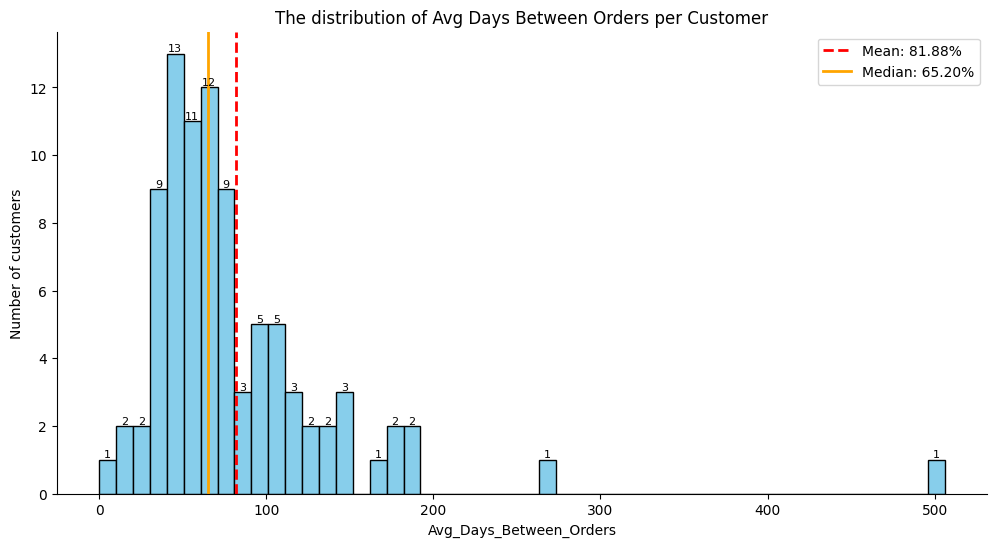

In [233]:
# יצירת גרף שמצייר את התפלגות הימים מהקניה האחרונה של הלקוחות
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6)) # הגדלתי קצת את הרוחב כדי שיהיה מקום למספרים

# 1. שומרים את הערכים שהפונקציה מחזירה
# counts = הגובה של כל עמודה (כמות הלקוחות)
# bins = הגבולות של העמודות
# patches = האובייקטים הגרפיים של העמודות עצמן
counts, bins, patches = plt.hist(customer_profile['Avg_Days_Between_Orders'], bins=50, color='skyblue', edgecolor='black')

# 2. לולאה שעוברת על כל עמודה ומוסיפה את המספר
for count, patch in zip(counts, patches):
    # נציג מספר רק אם יש שם ערך (כדי לא ללכלך את הגרף עם אפסים)
    if count > 0:
        # חישוב מיקום הטקסט:
        # X = המרכז של העמודה
        # Y = הגובה של העמודה
        x = patch.get_x() + patch.get_width() / 2
        y = patch.get_height()
        
        plt.text(x, y, int(count), ha='center', va='bottom', fontsize=8, color='black')

# חישוב הממוצע והחציון
mean_adbo = customer_profile['Avg_Days_Between_Orders'].mean()
median_adbo = customer_profile['Avg_Days_Between_Orders'].median()

# הוספת קווים אנכיים לממוצע וחציון
plt.axvline(mean_adbo, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_adbo:.2f}%')
plt.axvline(median_adbo, color='orange', linestyle='-', linewidth=2, label=f'Median: {median_adbo:.2f}%')

plt.title('The distribution of Avg Days Between Orders per Customer')
plt.xlabel('Avg_Days_Between_Orders')
plt.ylabel('Number of customers')
plt.legend()

# הסרת הגבול העליון והימני למראה נקי יותר (אופציונלי)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.show()

we can see that most customer order every 60 days eash and when customer is more then 80 days off mybe we will need to remaind him or give him a discount

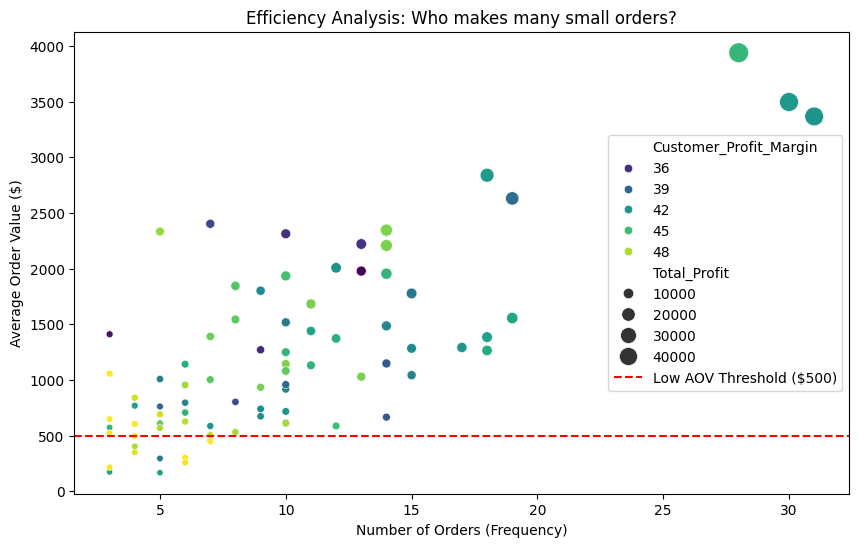


--- לקוחות 'תחזוקה גבוהה' (High Maintenance) ---


,CustomerID,Order_Count,Average_Order_Value,Total_Profit,Customer_Profit_Margin
14,COMMI,5,762.15,1491.9500,39.15
26,FURIB,8,803.43,2414.9225,37.57


In [234]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))

# נסנן קצת רעשים (לקוחות זעירים)
active_customers = customer_profile[customer_profile['Order_Count'] > 2]

# גרף פיזור: ציר X = מספר הזמנות, ציר Y = גודל הזמנה ממוצע
sns.scatterplot(data=active_customers, x='Order_Count', y='Average_Order_Value', 
                hue='Customer_Profit_Margin', size='Total_Profit', sizes=(20, 200), palette='viridis')

# הוספת קו אדום שמסמן "אזור סכנה" (למשל הזמנות מתחת ל-500$)
plt.axhline(y=500, color='red', linestyle='--', label='Low AOV Threshold ($500)')

plt.title('Efficiency Analysis: Who makes many small orders?')
plt.xlabel('Number of Orders (Frequency)')
plt.ylabel('Average Order Value ($)')
plt.legend()
plt.show()

# הדפסת הרשימה של הלקוחות ה"מטרטרים" (הרבה הזמנות, סכום קטן)
high_maintenance = active_customers[(active_customers['Order_Count'] < 9) & (active_customers['Average_Order_Value'] <1000)&(active_customers['Customer_Profit_Margin'] <40) ] 
print("\n--- לקוחות 'תחזוקה גבוהה' (High Maintenance) ---")
high_maintenance[['CustomerID', 'Order_Count', 'Average_Order_Value', 'Total_Profit','Customer_Profit_Margin']]

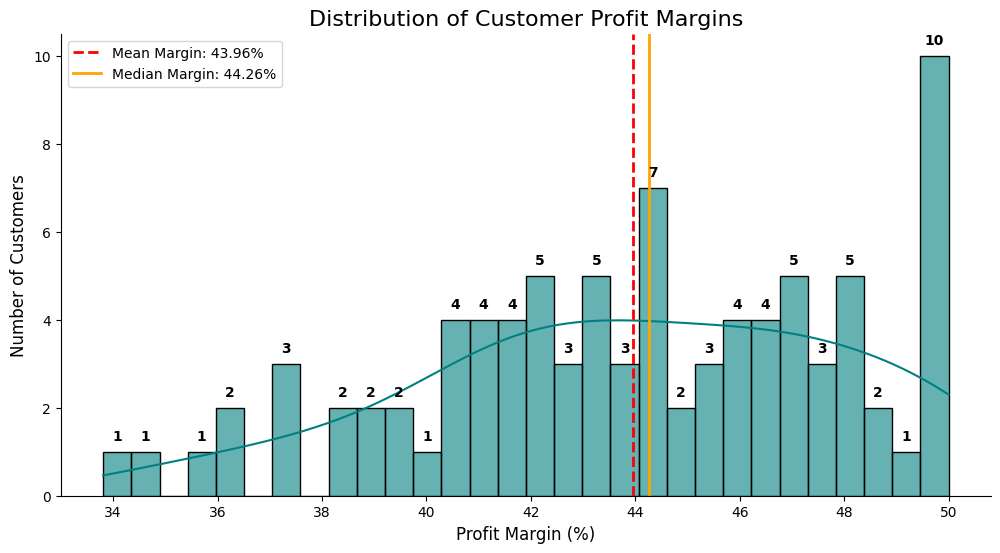

In [235]:
# הגדרת גודל הגרף
plt.figure(figsize=(12, 6))

# חישוב הממוצע והחציון
mean_margin = customer_profile['Customer_Profit_Margin'].mean()
median_margin = customer_profile['Customer_Profit_Margin'].median()
ax = sns.histplot(data=customer_profile, x='Customer_Profit_Margin', kde=True, color='teal', bins=30, alpha=0.6)

# 2. הלולאה הקסומה להוספת המספרים
for p in ax.patches:
    height = p.get_height() # הגובה של העמודה = מספר הלקוחות
    
    # נציג מספר רק אם יש שם לקוחות (כדי לא ללכלך עם אפסים)
    if height > 0:
        # חישוב המיקום: אמצע העמודה (X) וקצת מעל הגובה שלה (Y)
        x = p.get_x() + p.get_width() / 2
        y = height + 0.2 # הוספתי רווח קטן כדי שהמספר לא יישב על הקו
        
        # כתיבת הטקסט
        ax.text(x, y, int(height), ha='center', va='bottom', fontsize=10, color='black', fontweight='bold')

# הוספת קווים אנכיים לממוצע וחציון
plt.axvline(mean_margin, color='red', linestyle='--', linewidth=2, label=f'Mean Margin: {mean_margin:.2f}%')
plt.axvline(median_margin, color='orange', linestyle='-', linewidth=2, label=f'Median Margin: {median_margin:.2f}%')

# עיצוב וטקסטים
plt.title('Distribution of Customer Profit Margins', fontsize=16)
plt.xlabel('Profit Margin (%)', fontsize=12)
plt.ylabel('Number of Customers', fontsize=12)
plt.legend() # מציג את המקרא של הקווים

# הסרת גבולות מיותרים למראה נקי
sns.despine()

plt.show()

In [236]:
# בדיקה למה יש רווח כלכך גדול ממספר לקוחות וכל השאר רווחים יותר קטנים
# 1. מיון הלקוחות לפי רווח ותצוגת המובילים
top_profit_customers = customer_profile.nlargest(10, 'Customer_Profit_Margin')[['CustomerID', 'Total_Sales', 'Total_Profit', 'Order_Count', 'Customer_Profit_Margin', 'Average_Order_Value']]
print("--- 10 לקוחות עם הרווח הגבוה ביותר ---")
print(top_profit_customers)


--- 10 לקוחות עם הרווח הגבוה ביותר ---
   CustomerID  Total_Sales  Total_Profit  Order_Count  Customer_Profit_Margin  \
5       BLAUS      3239.80      1619.900            7                   50.00   
11      CACTU      1814.80       907.400            6                   50.00   
24      FRANR      3172.16      1586.080            3                   50.00   
38      LACOR      1992.05       996.025            4                   50.00   
51      NORTS       649.00       324.500            3                   50.00   
71      SPECD      2423.35      1211.675            4                   50.00   
75      THECR      1947.24       973.620            3                   50.00   
79      TRAIH      1571.20       785.600            3                   50.00   
87      WILMK      3161.35      1580.675            7                   50.00   
25      FRANS      1545.70       766.520            6                   49.59   

    Average_Order_Value  
5                462.83  
11               

In [237]:
print(customer_profile.columns)

Index(['CustomerID', 'Total_Sales', 'Total_Profit', 'Order_Count',
       'Total_Quantity', 'First_Purchase', 'Last_Purchase', 'Country',
       'Avg_Days_to_Ship', 'Avg_Gross_Profit_Margin(%)', 'Average_Order_Value',
       'Customer_Profit_Margin', 'Buyer_Percentage', 'Lifespan_Days',
       'Days_Since_Last_Order', 'Avg_Days_Between_Orders', 'Customer_Segment'],
      dtype='object')


בדיקה איזה לקוחות הולכים לעזוב אותנו

In [238]:
# יצירת התראה: האם הלקוח "מאחר" בצורה חריגה?
# נגדיר לקוח בסיכון אם עבר זמן כפול מהממוצע שלו מאז הקנייה האחרונה
# (וגם נסנן לקוחות שקנו רק פעם אחת כי אין להם ממוצע)
customer_profile['Is_At_Risk'] = (customer_profile['Days_Since_Last_Order'] > (customer_profile['Avg_Days_Between_Orders'] * 2)) & (customer_profile['Order_Count'] > 1)

# בוא נראה כמה כסף בסכנה (לקוחות זהב שנמצאים בסיכון)
risk_analysis = customer_profile[customer_profile['Is_At_Risk'] == True]

print(f"יש לך {len(risk_analysis)} לקוחות קבועים שנמצאים בסיכון נטישה!")
print("--- הלקוחות החשובים ביותר שצריך להתקשר אליהם מחר ---")
print(risk_analysis.sort_values(by='Total_Profit', ascending=False)[['CustomerID', 'Total_Profit', 'Avg_Days_Between_Orders', 'Days_Since_Last_Order']])

יש לך 6 לקוחות קבועים שנמצאים בסיכון נטישה!
--- הלקוחות החשובים ביותר שצריך להתקשר אליהם מחר ---
   CustomerID  Total_Profit  Avg_Days_Between_Orders  Days_Since_Last_Order
49      MEREP     10432.940                     31.5                    188
6       BLONP      7231.055                     53.6                    114
20      FAMIA      1721.700                     59.8                    187
34      HUNGC      1420.675                     69.0                    240
38      LACOR       996.025                     18.0                     43
41      LAZYK       160.000                     62.0                    349


In [239]:
# יצוא טבלה לאקסל 
# customer_profile.to_excel('customer_profile1.xlsx',index=False)

In [240]:
# קיבוץ לפי מדינה כדי לראות איפה הכסף הגדול ואיפה המרווח הנמוך
geo_analysis = customer_profile.groupby('Country').agg({
    'CustomerID': 'count',              # כמה לקוחות יש שם
    'Total_Sales': 'sum',               # סך מכירות
    'Total_Profit': 'sum',              # סך רווח
    'Customer_Profit_Margin': 'mean',   # ממוצע רווחיות באחוזים
    'Avg_Days_to_Ship': 'mean'          # כמה זמן לוקח לשלוח לשם
}).reset_index()
geo_analysis['total_profit_score'] = geo_analysis['Total_Profit'].rank(ascending=False)
geo_analysis['total_sales_score'] = geo_analysis['Total_Sales'].rank(ascending=False)

geo_analysis['Country_Profit_Margin']=(geo_analysis['Total_Profit']/geo_analysis['Total_Sales'])*100

geo_analysis['Country_Profit_Margin_score'] = geo_analysis['Country_Profit_Margin'].rank(ascending=False)
# נמיין לפי רווחיות (מהנמוך לגבוה) - נחפש מדינות שאנחנו מפסידים בהן אחוזים
print("--- המדינות עם הרווחיות (Margin) הנמוכה ביותר ---")
print(geo_analysis[geo_analysis['CustomerID'] > 3].sort_values(by='Country_Profit_Margin').head(6))
print('\n number of uniqe countries')
print(geo_analysis['Country'].count())

--- המדינות עם הרווחיות (Margin) הנמוכה ביותר ---
      Country  CustomerID  Total_Sales  Total_Profit  Customer_Profit_Margin  \
3      Brazil           9  106925.7765    45058.4115               42.218889   
20  Venezuela           4   56810.6290    23987.0340               41.717500   
7      France          10   81358.3225    34553.7425               44.615000   
19        USA          13  245584.6105   105215.4205               44.876923   
15      Spain           4   17983.2000     7835.4600               42.007500   
8     Germany          11  230284.6335   101469.2985               44.510000   

    Avg_Days_to_Ship  total_profit_score  total_sales_score  \
3           7.864516                 4.0                4.0   
20          7.260753                 7.0                7.0   
7           7.790863                 5.0                5.0   
19         10.134406                 1.0                1.0   
15          9.188072                16.0               16.0   
8          

בדיקה האם יש מדינות שאחוז המכירות בהם גבוהה אבל הרווח נמוך

--- המדינות הכי 'מסוכנות': נפח מכירות ענק, רווח נמוך ---
      Country  Total_Sales  Country_Profit_Margin  total_sales_score
4      Canada   50196.2900              38.341907                9.0
9     Ireland   49979.9050              39.577806               10.0
1     Austria  128003.8385              41.413831                3.0
3      Brazil  106925.7765              42.139896                4.0
20  Venezuela   56810.6290              42.222792                7.0
7      France   81358.3225              42.471061                5.0
19        USA  245584.6105              42.842839                1.0
16     Sweden   54495.1400              43.266776                8.0
8     Germany  230284.6335              44.062557                2.0
18         UK   58971.3100              45.002790                6.0


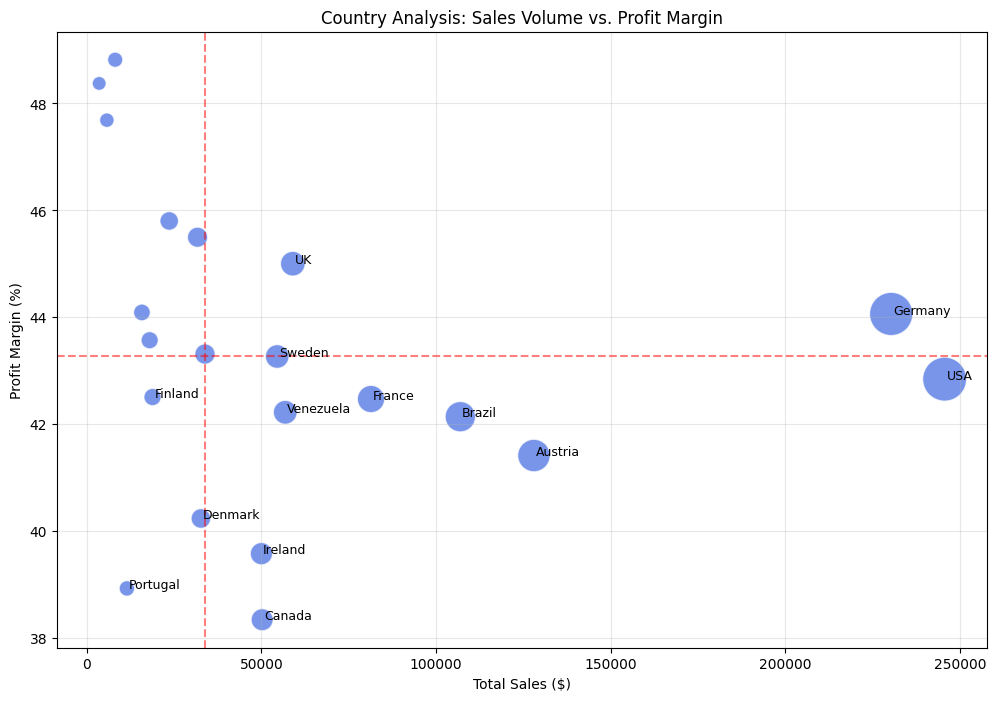

In [241]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- חלק 1: הטבלה (מיון מדינות עם מכירות גבוהות ורווח נמוך) ---

# 1. סינון: ניקח רק את המדינות שנמצאות בטופ 10 במכירות
# (total_sales_score נמוך = דירוג גבוה)
top_selling_countries = geo_analysis[geo_analysis['total_sales_score'] <= 10]

# 2. מיון: מתוך הגדולות, נראה מי הכי פחות רווחית (מהנמוך לגבוה)
problematic_countries = top_selling_countries.sort_values(by='Country_Profit_Margin', ascending=True)

print("--- המדינות הכי 'מסוכנות': נפח מכירות ענק, רווח נמוך ---")
print(problematic_countries[['Country', 'Total_Sales', 'Country_Profit_Margin', 'total_sales_score']])


# --- חלק 2: הגרף המתוקן (משתמש ב-Total_Sales) ---

plt.figure(figsize=(12, 8))

# יצירת גרף הפיזור
sns.scatterplot(data=geo_analysis, 
                x='Total_Sales',              # שימוש בעמודה הנכונה
                y='Country_Profit_Margin', 
                size='Total_Profit',          # גודל העיגול לפי הרווח הכולל
                sizes=(100, 1000),            # טווח הגדלים
                color='royalblue',
                alpha=0.7,
                legend=False)

# הוספת קווי חציון (כדי לחלק ל-4 רביעים)
median_sales = geo_analysis['Total_Sales'].median()
median_margin = geo_analysis['Country_Profit_Margin'].median()

plt.axvline(x=median_sales, color='red', linestyle='--', alpha=0.5, label='Median Sales')
plt.axhline(y=median_margin, color='red', linestyle='--', alpha=0.5, label='Median Margin')

# הוספת שמות המדינות לגרף
# התיקון: שימוש ב-Total_Sales בלולאה
for i in range(len(geo_analysis)):
    
    current_sales = geo_analysis['Total_Sales'].iloc[i]
    current_margin = geo_analysis['Country_Profit_Margin'].iloc[i]
    country_name = geo_analysis['Country'].iloc[i]
    
    # נוסיף טקסט רק למדינות מעניינות (מעל החציון במכירות או מתחת לחציון ברווח)
    # כדי לא ללכלך את הגרף
    if current_sales > median_sales or current_margin < median_margin:
        plt.text(x=current_sales + 500,  # הזזה קטנה ימינה
                 y=current_margin, 
                 s=country_name, 
                 fontdict=dict(color='black', size=9))

plt.title('Country Analysis: Sales Volume vs. Profit Margin')
plt.xlabel('Total Sales ($)')
plt.ylabel('Profit Margin (%)')
plt.grid(True, alpha=0.3)

plt.show()

In [242]:
# # ייצוא הטבלה לאקסל 
# geo_analysis.to_excel('geo_analysis.xlsx',index=False)

עוברים לבדוק נתונים על המוצרים שלנו 

In [243]:
import numpy as np

# 1. בנייה מחדש של הטבלה עם כל העמודות הנחוצות (כולל ReorderLevel)
product_kpis = df_o_od_p.groupby(['ProductID', 'ProductName']).agg({
    'Sales': 'sum',                 # סך הכנסות
    'Profit': 'sum',                # סך רווח גולמי
    'Total_Cost': 'sum',            # עלות המכר (COGS) - חובה לחישוב Turnover
    'Quantity': 'sum',              # סך יחידות שנמכרו
    'OrderID': 'nunique',           # מספר הזמנות (ביקוש)
    'UnitsInStock': 'first',        # מלאי נוכחי (Snapshot)
    'ReorderLevel': 'first',        # נקודת הזמנה (לחישוב ממוצע)
    'UnitPrice_Cost': 'first',      # עלות ליחידה
    'CategoryID': 'first'         # קטגוריה (טוב לסינונים בדשבורד)
}).reset_index()

# 2. חישוב מלאי ממוצע משוער כיוון שאין לנו מלאי ממוצע אלא רק כמה מלאי יש עכשיו לכן חישבנו ממוצע כדי לקבל נתון מדויק בערך
# המלאי הממוצע הוא בערך האמצע בין המלאי הנוכחי לקו האדום
product_kpis['Estimated_Avg_Inventory_Qty'] = (product_kpis['UnitsInStock'] + product_kpis['ReorderLevel']) / 2

# טיפול במקרי קצה: אם גם המלאי וגם הקו האדום הם 0, נשים 1 כדי לא לחלק באפס
product_kpis['Estimated_Avg_Inventory_Qty'] = np.where(product_kpis['Estimated_Avg_Inventory_Qty'] == 0, 1, product_kpis['Estimated_Avg_Inventory_Qty'])

# 3. חישוב שווי המלאי הממוצע (הבסיס לחישוב היעילות)
product_kpis['Avg_Inventory_Value'] = product_kpis['Estimated_Avg_Inventory_Qty'] * product_kpis['UnitPrice_Cost']

# --- חישוב ה-KPIs המתקדמים ---

# A. Gross Profit Margin %
product_kpis['Gross_Margin_Percent'] = ((product_kpis['Profit'] / product_kpis['Sales']) * 100).round(2)

# B. Inventory Turnover (Corrected)
# נוסחה: COGS / Average Inventory Value
product_kpis['Inventory_Turnover'] = (product_kpis['Total_Cost'] / product_kpis['Avg_Inventory_Value']).round(2)

# C. GMROI (Corrected)
# נוסחה: Gross Profit / Average Inventory Value
product_kpis['GMROI'] = (product_kpis['Profit'] / product_kpis['Avg_Inventory_Value']).round(2)

# 4. סיווג המוצרים לפעולה (Action Buckets) - כדי שיהיה קל לסנן בדשבורד
# --- שלב 1: סיווג נפרד לכל מדד ---

# 2. חישוב הספים (Thresholds) באופן דינמי לפי רבעונים
# רף עליון (כוכבים) = אחוזון 75 (Top 25%)
roi_high_threshold = product_kpis['GMROI'].quantile(0.75)
# רף תחתון (בעייתיים) = אחוזון 25 (Bottom 25%)
roi_low_threshold = product_kpis['GMROI'].quantile(0.25)

# אותו דבר לתחלופה (Flow)
flow_fast_threshold = product_kpis['Inventory_Turnover'].quantile(0.75)
flow_slow_threshold = product_kpis['Inventory_Turnover'].quantile(0.25)


# 3. עדכון הפונקציות להשתמש במשתנים הדינמיים
def get_roi_status_dynamic(row):
    if row['GMROI'] >= roi_high_threshold:
        return 'High inv'
    elif row['GMROI'] <= roi_low_threshold:
        return 'Low inv'
    else:
        return 'normal inv' # האמצע

def get_flow_status_dynamic(row):
    if row['Inventory_Turnover'] >= flow_fast_threshold:
        return 'Fast Mover'
    elif row['Inventory_Turnover'] <= flow_slow_threshold:
        return 'Slow Mover'
    else:
        return 'Normal flow'

# הפעלת הפונקציות
product_kpis['investment_Status'] = product_kpis.apply(get_roi_status_dynamic, axis=1)
product_kpis['Flow_Status'] = product_kpis.apply(get_flow_status_dynamic, axis=1)

# --- שלב 2: המטריצה האסטרטגית  ---

def get_strategy(row):
    roi = row['investment_Status']
    flow = row['Flow_Status']
    
    # 1. הכוכבים (רווחי ומהיר)
    if roi == 'High inv' and flow == 'Fast Mover':
        return 'Super Star (Protect Stock)'
    
    # 2. הפרות החולבות (רווחי אבל רגיל)
    if roi == 'High inv' and flow == 'Normal':
        return 'slow but profitable (Maintain)'
        
    # 3. מוצרי נישה/יוקרה (רווחי מאוד אבל איטי)
    # זה לא מלאי מת, זה מוצר שצריך להחזיק ממנו קצת
    if roi == 'High inv' and flow == 'Slow Mover':
        return 'Luxury/Niche (Keep Low Stock)'
        
    # 4. עבודה בעיניים (מהיר אבל לא רווחי)
    if roi == 'Low inv' and flow == 'Fast Mover':
        return 'big sales low profit (Raise Price!)'
        
    # 5. הכלבים / מלאי מת (לא רווחי וגם איטי)
    if roi == 'Low inv' and flow == 'Slow Mover':
        # אם יש מלאי - זה דחוף לחסל. אם אין - פשוט לא להזמין.
        if row['UnitsInStock'] > 0:
            return 'Dead Stock (Liquidate ASAP)'
        else:
            return 'Do Not Reorder'
            
    return 'Standard Performance' # כל השאר

product_kpis['Strategic_Action'] = product_kpis.apply(get_strategy, axis=1)

# --- בדיקת התוצאות ---
product_kpis.head()




,ProductID,ProductName,Sales,Profit,Total_Cost,Quantity,OrderID,UnitsInStock,ReorderLevel,UnitPrice_Cost,CategoryID,Estimated_Avg_Inventory_Qty,Avg_Inventory_Value,Gross_Margin_Percent,Inventory_Turnover,GMROI,investment_Status,Flow_Status,Strategic_Action
0,1,Chai,12788.10,5336.10,7452.00,828,38,39,10,9.000,1,24.5,220.500,41.73,33.80,24.20,normal inv,Normal flow,Standard Performance
1,2,Chang,16355.96,6314.46,10041.50,1057,44,17,25,9.500,1,21.0,199.500,38.61,50.33,31.65,normal inv,Normal flow,Standard Performance
2,3,Aniseed Syrup,3044.00,1404.00,1640.00,328,12,13,25,5.000,2,19.0,95.000,46.12,17.26,14.78,normal inv,Normal flow,Standard Performance
3,4,Chef Anton's Cajun Seasoning,8567.90,3584.90,4983.00,453,20,53,0,11.000,2,26.5,291.500,41.84,17.09,12.30,normal inv,Normal flow,Standard Performance
4,5,Chef Anton's Gumbo Mix,5347.20,2166.05,3181.15,298,10,0,0,10.675,2,1.0,10.675,40.51,298.00,202.91,High inv,Fast Mover,Super Star (Protect Stock)


In [244]:
# החזרת כל המוצרים שיש להם dead stock או Do Not Reorder
# 1. הסינון: קח את product_kpis ותשמור רק שורות שבהן האסטרטגיה מכילה את המילה "Dead"
dead_stock_table = product_kpis[product_kpis['Strategic_Action'].isin(['Dead Stock (Liquidate ASAP)', 'Do Not Reorder'])]

# 2. המיון: סדר מהגבוה לנמוך לפי שווי המלאי (כדי לראות את הבעיות הגדולות ראשונות)
dead_stock_table = dead_stock_table.sort_values(by='Avg_Inventory_Value', ascending=False)

# 3. הצגה: נבחר רק את העמודות שרלוונטיות לדוח
cols_to_show = ['ProductName', 'Strategic_Action', 'Avg_Inventory_Value', 'UnitsInStock', 'GMROI','Inventory_Turnover','Estimated_Avg_Inventory_Qty']

print(f"נמצאו {len(dead_stock_table)} מוצרים לחיסול.")
print(f"סה'כ כסף תקוע במלאי מת: ${dead_stock_table['Avg_Inventory_Value'].sum():,.2f}")
print("\n--- רשימת Dead Stock (עשרת הגדולים) ---")
dead_stock_table[cols_to_show].head(10)

נמצאו 20 מוצרים לחיסול.
סה'כ כסף תקוע במלאי מת: $9,568.09

--- רשימת Dead Stock (עשרת הגדולים) ---


,ProductName,Strategic_Action,Avg_Inventory_Value,UnitsInStock,GMROI,Inventory_Turnover,Estimated_Avg_Inventory_Qty
60,Sirop d'יrable,Dead Stock (Liquidate ASAP),983.250,113,5.86,8.74,69.0
5,Grandma's Boysenberry Spread,Dead Stock (Liquidate ASAP),906.250,120,3.72,4.15,72.5
26,Schoggi Schokolade,Dead Stock (Liquidate ASAP),867.025,49,8.18,9.24,39.5
11,Queso Manchego La Pastora,Dead Stock (Liquidate ASAP),817.000,86,7.00,8.00,43.0
54,Pגtי chinois,Dead Stock (Liquidate ASAP),810.000,115,8.14,13.38,67.5
8,Mishi Kobe Niku,Dead Stock (Liquidate ASAP),703.250,29,3.72,6.55,14.5
21,Gustaf's Knהckebrצd,Dead Stock (Liquidate ASAP),677.250,104,5.12,5.40,64.5
35,Inlagd Sill,Dead Stock (Liquidate ASAP),627.000,112,9.27,12.20,66.0
33,Sasquatch Ale,Dead Stock (Liquidate ASAP),441.000,111,6.37,8.03,63.0
72,Rצd Kaviar,Dead Stock (Liquidate ASAP),397.500,101,4.53,5.53,53.0


In [245]:
# המוצרים שצריך להגביר להם מכירים (נגמר מהר אבל לא רווחי)
fast_low_profit_table = product_kpis[product_kpis['Strategic_Action']=='big sales low profit (Raise Price!)']
fast_low_profit_table = fast_low_profit_table.sort_values(by='Avg_Inventory_Value', ascending=False)
print(f"נמצאו {len(fast_low_profit_table)} מוצרים להעלאת מחיר.")
print(f"סה'כ כסף תקוע במלאי מת: ${fast_low_profit_table['Avg_Inventory_Value'].sum():,.2f}")
print("\n--- רשימת fast sale low profit (עשרת הגדולים) ---")
fast_low_profit_table[cols_to_show].head(10)

נמצאו 0 מוצרים להעלאת מחיר.
סה'כ כסף תקוע במלאי מת: $0.00

--- רשימת fast sale low profit (עשרת הגדולים) ---


,ProductName,Strategic_Action,Avg_Inventory_Value,UnitsInStock,GMROI,Inventory_Turnover,Estimated_Avg_Inventory_Qty


In [246]:

product_kpis.describe()

,ProductID,Sales,Profit,Total_Cost,Quantity,OrderID,UnitsInStock,ReorderLevel,UnitPrice_Cost,CategoryID,Estimated_Avg_Inventory_Qty,Avg_Inventory_Value,Gross_Margin_Percent,Inventory_Turnover,GMROI
count,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000
mean,39.000000,16438.870643,7027.394604,9411.476039,666.454545,27.987013,40.506494,12.467532,14.433182,4.116883,26.538961,317.223474,42.857403,74.327273,54.861169
std,22.371857,20365.061468,8616.333209,11757.578535,329.244492,12.944714,36.147222,10.931105,16.907556,2.395028,19.988445,329.144659,2.459048,160.361745,116.642497
min,1.000000,1368.712500,488.962500,879.750000,95.000000,5.000000,0.000000,0.000000,1.250000,1.000000,1.000000,10.675000,35.720000,4.150000,3.720000
25%,20.000000,5862.620000,2343.925000,3288.000000,404.000000,17.000000,15.000000,0.000000,6.625000,2.000000,13.000000,110.250000,41.510000,13.490000,10.290000
50%,39.000000,10672.650000,4545.150000,6127.500000,697.000000,30.000000,26.000000,10.000000,9.750000,4.000000,20.000000,217.000000,43.100000,28.460000,21.090000
75%,58.000000,19551.025000,8091.049500,11362.750000,828.000000,38.000000,61.000000,25.000000,16.625000,6.000000,38.500000,397.500000,44.110000,53.620000,40.620000
max,77.000000,141396.735000,59316.485000,82080.250000,1577.000000,54.000000,125.000000,30.000000,131.750000,8.000000,76.500000,2108.000000,48.700000,978.000000,698.840000


In [247]:
product_kpis.head()

,ProductID,ProductName,Sales,Profit,Total_Cost,Quantity,OrderID,UnitsInStock,ReorderLevel,UnitPrice_Cost,CategoryID,Estimated_Avg_Inventory_Qty,Avg_Inventory_Value,Gross_Margin_Percent,Inventory_Turnover,GMROI,investment_Status,Flow_Status,Strategic_Action
0,1,Chai,12788.10,5336.10,7452.00,828,38,39,10,9.000,1,24.5,220.500,41.73,33.80,24.20,normal inv,Normal flow,Standard Performance
1,2,Chang,16355.96,6314.46,10041.50,1057,44,17,25,9.500,1,21.0,199.500,38.61,50.33,31.65,normal inv,Normal flow,Standard Performance
2,3,Aniseed Syrup,3044.00,1404.00,1640.00,328,12,13,25,5.000,2,19.0,95.000,46.12,17.26,14.78,normal inv,Normal flow,Standard Performance
3,4,Chef Anton's Cajun Seasoning,8567.90,3584.90,4983.00,453,20,53,0,11.000,2,26.5,291.500,41.84,17.09,12.30,normal inv,Normal flow,Standard Performance
4,5,Chef Anton's Gumbo Mix,5347.20,2166.05,3181.15,298,10,0,0,10.675,2,1.0,10.675,40.51,298.00,202.91,High inv,Fast Mover,Super Star (Protect Stock)


In [248]:
# --- רשימה 1: "בית הקברות" (Dead Stock) ---
# התנאים:
# 1. ROI נמוך (Low ROI)
# 2. תזוזה איטית (Slow Mover)
# 3. יש מלאי פיזי במחסן (UnitsInStock > 0) - אחרת אין מה לחסל
dead_stock_list = product_kpis[
    (product_kpis['investment_Status'] == 'Low inv') & 
    (product_kpis['Flow_Status'] == 'Slow Mover') & 
    (product_kpis['UnitsInStock'] > 0)
].sort_values(by='Avg_Inventory_Value', ascending=False) # נמיין לפי שווי המלאי כדי לדעת איפה תקוע הכי הרבה כסף

print(f"--- רשימת חיסול: נמצאו {len(dead_stock_list)} מוצרים שתוקעים כסף ---")
dead_stock_list[['ProductName', 'UnitsInStock', 'Avg_Inventory_Value', 'Inventory_Turnover', 'GMROI']].head(7)




--- רשימת חיסול: נמצאו 20 מוצרים שתוקעים כסף ---


,ProductName,UnitsInStock,Avg_Inventory_Value,Inventory_Turnover,GMROI
60,Sirop d'יrable,113,983.250,8.74,5.86
5,Grandma's Boysenberry Spread,120,906.250,4.15,3.72
26,Schoggi Schokolade,49,867.025,9.24,8.18
11,Queso Manchego La Pastora,86,817.000,8.00,7.00
54,Pגtי chinois,115,810.000,13.38,8.14
8,Mishi Kobe Niku,29,703.250,6.55,3.72
21,Gustaf's Knהckebrצd,104,677.250,5.40,5.12


In [249]:

# --- רשימה 2: "הכי פחות משתלמים" (Lowest GMROI) ---
# אלו פשוט המוצרים בתחתית הרשימה של GMROI, ללא קשר לכמות המלאי
# (אלו מוצרים שהמודל הכלכלי שלהם כרגע לא עובד טוב)
lowest_gmroi_list = product_kpis.sort_values(by='GMROI', ascending=True).head(15)

print("\n--- המוצרים עם ה-GMROI הנמוך ביותר (דורשים התערבות) ---")
lowest_gmroi_list[['ProductName', 'GMROI', 'Gross_Margin_Percent', 'Inventory_Turnover']].head(10)


--- המוצרים עם ה-GMROI הנמוך ביותר (דורשים התערבות) ---


,ProductName,GMROI,Gross_Margin_Percent,Inventory_Turnover
5,Grandma's Boysenberry Spread,3.72,47.28,4.15
8,Mishi Kobe Niku,3.72,36.24,6.55
47,Chocolade,3.84,35.72,6.90
49,Valkoinen suklaa,3.96,44.46,4.95
24,NuNuCa Nu-Nougat-Creme,3.98,39.91,6.00
72,Rצd Kaviar,4.53,45.02,5.53
36,Gravad lax,4.54,39.56,6.94
14,Genen Shouyu,4.92,47.03,5.55
66,Laughing Lumberjack Lager,5.11,46.26,5.94
21,Gustaf's Knהckebrצd,5.12,48.70,5.40


In [250]:
# # ייצוא לאקסל 
# product_kpis.to_excel('product_kpis.xlsx',index=False)

In [251]:
# 1. הכנת הנתונים: אנחנו צריכים רק את מספר ההזמנה ושם המוצר
# נסנן הזמנות שיש בהן רק מוצר אחד (כי אי אפשר למצוא בהן זוגות)
order_counts = df_o_od_p.groupby('OrderID').size()
orders_with_multiple_items = order_counts[order_counts > 1].index
basket_data = df_o_od_p[df_o_od_p['OrderID'].isin(orders_with_multiple_items)][['OrderID', 'ProductName']]

# 2. ביצוע "מיזוג עצמי" (Self Join)
# אנחנו מחברים את הטבלה לעצמה לפי מספר הזמנה, כדי לקבל את כל השילובים האפשריים בכל הזמנה
product_pairs = pd.merge(basket_data, basket_data, on='OrderID')

# 3. סינון זוגות כפולים ומיותרים
# אנחנו לא רוצים שמוצר יופיע עם עצמו (A עם A)
# ואנחנו רוצים למנוע כפילויות של סדר (שלא יופיע גם A-B וגם B-A)
product_pairs = product_pairs[product_pairs['ProductName_x'] < product_pairs['ProductName_y']]

# 4. ספירת הזוגות
pair_counts = product_pairs.groupby(['ProductName_x', 'ProductName_y']).size().reset_index(name='Frequency')

# 5. מיון לפי השכיחות (הזוגות הכי נפוצים)
top_pairs = pair_counts.sort_values(by='Frequency', ascending=False).head(10)

print("--- עשרת הצמדים הנמכרים ביותר ביחד (הזדמנות לבאנדלים) ---")
top_pairs


--- עשרת הצמדים הנמכרים ביותר ביחד (הזדמנות לבאנדלים) ---


,ProductName_x,ProductName_y,Frequency
1476,Sir Rodney's Scones,Sirop d'יrable,8
654,Gorgonzola Telino,Pavlova,7
1296,Pavlova,Tarte au sucre,6
133,Camembert Pierrot,Flotemysost,6
650,Gorgonzola Telino,Mozzarella di Giovanni,6
1208,Nord-Ost Matjeshering,Tourtiטre,6
162,Camembert Pierrot,Pavlova,6
1336,Pגtי chinois,Tarte au sucre,5
1026,Lakkalikצצri,Raclette Courdavault,5
1123,Manjimup Dried Apples,Sir Rodney's Scones,5


עוברים לבדיקת העובדים

In [252]:
# 1. קיבוץ הנתונים לפי עובד
employee_perf = df_o_od_p.groupby('EmployeeID').agg({
    'Sales': 'sum',            # סך מכירות
    'Profit': 'sum',           # סך רווח נקי
    'OrderID': 'nunique',      # מספר עסקאות שסגר
    'Discount': 'mean'         # ממוצע גובה ההנחה
}).reset_index()

# 2. חישוב מדדים נגזרים
# המרה לאחוזים שיהיה קריא
employee_perf['Avg_Discount_Percent'] = (employee_perf['Discount'] * 100).round(2)

# גודל עסקה ממוצע (האם הוא עושה Upsell?)
employee_perf['Avg_Order_Value'] = (employee_perf['Sales'] / employee_perf['OrderID']).round(0)

# רווחיות העובד באחוזים (עד כמה הוא שומר על המרווח)
employee_perf['Employee_Profit_Margin'] = ((employee_perf['Profit'] / employee_perf['Sales']) * 100).round(2)

# 3. מיון לפי רווח (השורה התחתונה)
employee_perf = employee_perf.sort_values(by='Profit', ascending=False)

print("--- טבלת ביצועי עובדים (ממוין לפי רווח) ---")
employee_perf.head(10)

--- טבלת ביצועי עובדים (ממוין לפי רווח) ---


,EmployeeID,Sales,Profit,OrderID,Discount,Avg_Discount_Percent,Avg_Order_Value,Employee_Profit_Margin
3,4,232890.8460,95335.8560,156,0.061310,6.13,1493.0,40.94
2,3,202812.8430,90010.1080,127,0.049688,4.97,1597.0,44.38
0,1,192107.6045,84248.7095,123,0.049246,4.92,1562.0,43.85
1,2,166537.7550,73840.1950,96,0.043776,4.38,1735.0,44.34
7,8,126862.2775,54886.8475,104,0.056154,5.62,1220.0,43.26
6,7,124568.2350,48767.1400,72,0.073580,7.36,1730.0,39.15
8,9,77308.0665,34024.7665,43,0.068224,6.82,1798.0,44.01
5,6,73913.1295,32076.4045,67,0.054464,5.45,1103.0,43.40
4,5,68792.2825,27919.3575,42,0.066667,6.67,1638.0,40.59


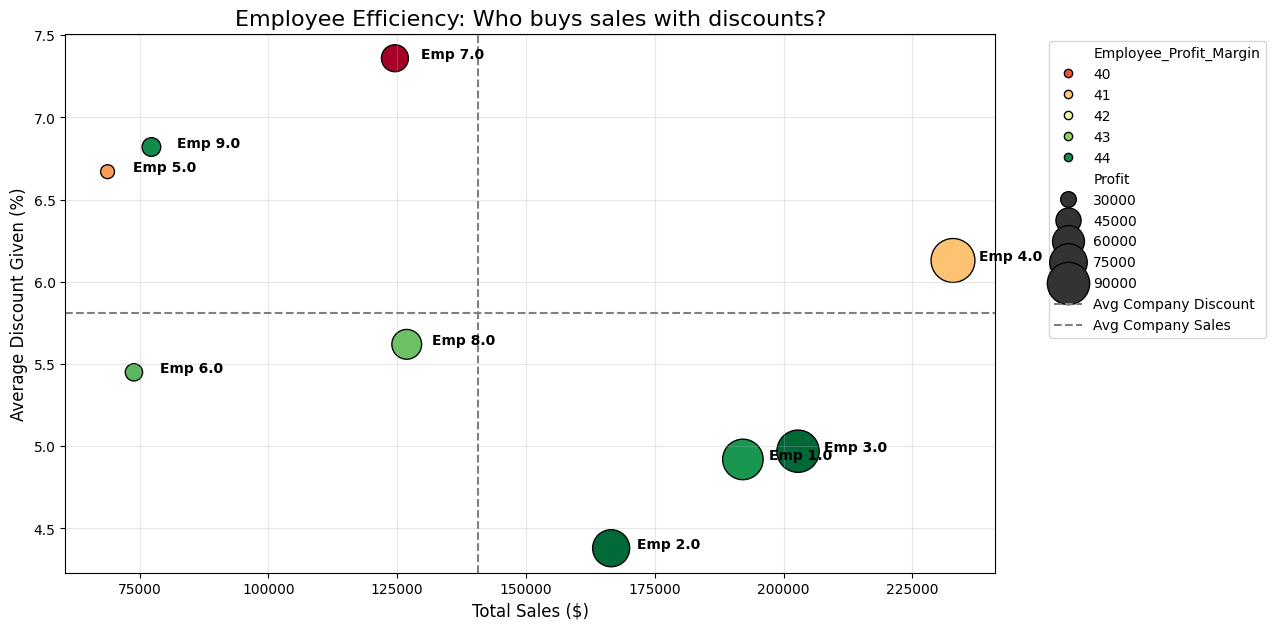

In [253]:
plt.figure(figsize=(12, 7))

# נחשב את הממוצע של החברה כדי לצייר קווים אדומים
avg_company_discount = employee_perf['Avg_Discount_Percent'].mean()
avg_company_sales = employee_perf['Sales'].mean()

# יצירת גרף פיזור
# ציר X: מכירות
# ציר Y: אחוז הנחה
# גודל נקודה: הרווח שהביא
sns.scatterplot(data=employee_perf, 
                x='Sales', 
                y='Avg_Discount_Percent', 
                size='Profit', 
                sizes=(100, 1000), 
                hue='Employee_Profit_Margin', # צבע לפי יעילות
                palette='RdYlGn', # אדום = יעילות נמוכה, ירוק = גבוהה
                edgecolor='black')

# הוספת קווי אמצע (Benchmark)
plt.axhline(y=avg_company_discount, color='gray', linestyle='--', label='Avg Company Discount')
plt.axvline(x=avg_company_sales, color='gray', linestyle='--', label='Avg Company Sales')

# הוספת תוויות לעובדים
for i in range(employee_perf.shape[0]):
    row = employee_perf.iloc[i]
    plt.text(row['Sales']+5000, row['Avg_Discount_Percent'], 
             f"Emp {row['EmployeeID']}", fontsize=10, weight='bold')

plt.title('Employee Efficiency: Who buys sales with discounts?', fontsize=16)
plt.xlabel('Total Sales ($)', fontsize=12)
plt.ylabel('Average Discount Given (%)', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)

plt.show()

In [254]:
# חישוב ממוצעים לסינון
avg_margin = employee_perf['Employee_Profit_Margin'].mean()

# סינון הבעייתיים
problematic_employees = employee_perf[
    (employee_perf['Avg_Discount_Percent'] > avg_company_discount) &
    (employee_perf['Employee_Profit_Margin'] < avg_margin)
]

print(f"\n--- דוח חריגים: עובדים שנותנים יותר מדי הנחות (מעל {avg_company_discount:.1f}%) ---")
print(problematic_employees[['EmployeeID', 'Avg_Discount_Percent', 'Employee_Profit_Margin', 'Profit']])

# חישוב: כמה כסף היינו מרוויחים אם הם היו נותנים רק את ההנחה הממוצעת?
# (חישוב גס להמחשת הפוטנציאל)
potential_saving = 0
for index, row in problematic_employees.iterrows():
    excess_discount = (row['Avg_Discount_Percent'] - avg_company_discount) / 100
    potential_saving += row['Sales'] * excess_discount

print(f"\n$$$ פוטנציאל חיסכון שנתי: ${potential_saving:,.0f} אם נגביל את ההנחות שלהם לממוצע $$$")


--- דוח חריגים: עובדים שנותנים יותר מדי הנחות (מעל 5.8%) ---
   EmployeeID  Avg_Discount_Percent  Employee_Profit_Margin      Profit
3           4                  6.13                   40.94  95335.8560
6           7                  7.36                   39.15  48767.1400
4           5                  6.67                   40.59  27919.3575

$$$ פוטנציאל חיסכון שנתי: $3,253 אם נגביל את ההנחות שלהם לממוצע $$$


In [255]:
# # ייצוא לאקסל
# employee_perf.to_excel('employee_perf.xlsx',index=False)

בדיקת הספקים

In [256]:
# 1. חישוב ימי איחור (רק אם נשלח אחרי התאריך המבוקש)
# אם ShippedDate ריק (עדיין לא נשלח), נתעלם
df_logistics = df_o_od_p.dropna(subset=['ShippedDate']).copy()

# חישוב ההפרש בימים: תאריך משלוח פחות תאריך נדרש
df_logistics['Days_Overdue'] = (df_logistics['ShippedDate'] - df_logistics['RequiredDate']).dt.days

# יצירת דגל: האם היה איחור? (1 אם איחר, 0 אם בזמן)
df_logistics['Is_Late'] = df_logistics['Days_Overdue'].apply(lambda x: 1 if x > 0 else 0)

# 2. ניתוח לפי חברת שילוח (ShipVia)
shipping_performance = df_logistics.groupby('ShipVia').agg({
    'OrderID': 'nunique',       # סך משלוחים
    'Is_Late': 'sum',           # כמה איחרו
    'Freight': 'mean'           # עלות משלוח ממוצעת
}).reset_index()

# חישוב אחוז האיחורים
shipping_performance['Late_Rate_Percent'] = ((shipping_performance['Is_Late'] / shipping_performance['OrderID']) * 100).round(2)

print("--- ביצועי חברות השילוח (מי מאחר הכי הרבה?) ---")
shipping_performance

--- ביצועי חברות השילוח (מי מאחר הכי הרבה?) ---


,ShipVia,OrderID,Is_Late,Freight,Late_Rate_Percent
0,1,245,31,81.318884,12.65
1,2,315,36,109.798744,11.43
2,3,249,25,99.481640,10.04


In [257]:
# # ייצוא לאקסל
# shipping_performance.to_excel('shipping_performance.xlsx',index=False)

In [258]:
# נשתמש בטבלת product_kpis שיצרנו קודם (שמכילה את הסטטוסים)
# אבל קודם צריך למזג אליה את ה-SupplierID מהטבלה המקורית
product_suppliers = df_o_od_p[['ProductID', 'SupplierID']].drop_duplicates() 
# מיזוג
supplier_analysis_df = pd.merge(product_kpis, product_suppliers, on='ProductID', how='left')

# קיבוץ לפי ספק
bad_suppliers = supplier_analysis_df.groupby('SupplierID').agg({
    'ProductID': 'count',                                    # כמה מוצרים הוא מספק לנו
    'Avg_Inventory_Value': 'sum',                            # כמה כסף מושקע אצלו
    # נספור כמה מוצרים שלו הם בסטטוס 'Dead Stock' (נניח שקראנו לזה ככה ב-Strategic_Action)
    'Strategic_Action': lambda x: (x.str.contains('Dead', na=False)).sum()
}).rename(columns={'Strategic_Action': 'Dead_Products_Count'})

# חישוב אחוז המוצרים הכושלים של הספק
bad_suppliers['Failure_Rate'] = ((bad_suppliers['Dead_Products_Count'] / bad_suppliers['ProductID']) * 100).round(1)

print("--- הספקים עם אחוז הכישלונות הגבוה ביותר ---")
bad_suppliers.sort_values(by='Failure_Rate', ascending=False)

--- הספקים עם אחוז הכישלונות הגבוה ביותר ---


,ProductID,Avg_Inventory_Value,Dead_Products_Count,Failure_Rate
SupplierID,,,,
9,2,870.7500,2,100.0
27,1,271.6250,1,100.0
17,3,1258.5000,3,100.0
11,3,1355.1375,2,66.7
16,3,815.5000,2,66.7
21,2,332.5000,1,50.0
22,2,213.0000,1,50.0
29,2,1192.7750,1,50.0
25,2,867.7375,1,50.0


In [259]:
# # ייצוא לאקסל
# bad_suppliers.to_excel('bad_suppliers.xlsx',index=False)

In [260]:
# חישוב נתונים כלליים לשקופית פתיחה
overview_data = {
    # --- הקשר זמן ---
    'Start Date': df_o_od_p['OrderDate'].min().strftime('%d/%m/%Y'),
    'End Date': df_o_od_p['OrderDate'].max().strftime('%d/%m/%Y'),
    'Total Days': (df_o_od_p['OrderDate'].max() - df_o_od_p['OrderDate'].min()).days,

    # --- פיננסי ---
    'Total Revenue ($)': df_o_od_p['Sales'].sum(),
    'Total Profit ($)': df_o_od_p['Profit'].sum(),
    'Global Margin (%)': (df_o_od_p['Profit'].sum() / df_o_od_p['Sales'].sum()) * 100,

    # --- יעילות ---
    'Avg Order Value ($)': df_o_od_p.groupby('OrderID')['Sales'].sum().mean(),
    'Avg Items per Order': df_o_od_p.groupby('OrderID')['Quantity'].sum().mean(),
    'Avg Discount (%)': df_o_od_p['Discount'].mean() * 100,

    # --- היקף ---
    'Total Orders': df_o_od_p['OrderID'].nunique(),
    'Active Customers': df_o_od_p['CustomerID'].nunique(),
    'Active Products': df_o_od_p['ProductID'].nunique(),
    'Countries Served': df_o_od_p['ShipCountry'].nunique()
}

# הדפסה יפה למסך
print("--- נתונים לשקופית Overview ---")
print(f"תקופת פעילות: {overview_data['Start Date']} עד {overview_data['End Date']} ({overview_data['Total Days']} ימים)")
print("-" * 30)
print(f"מחזור מכירות כולל: ${overview_data['Total Revenue ($)']:,.0f}")
print(f"רווח נקי כולל:    ${overview_data['Total Profit ($)']:,.0f}")
print(f"אחוז רווחיות חברה: {overview_data['Global Margin (%)']:.2f}%")
print("-" * 30)
print(f"גודל סל ממוצע:    ${overview_data['Avg Order Value ($)']:,.0f}")
print(f"ממוצע פריטים להזמנה: {overview_data['Avg Items per Order']:.1f}")
print(f"הנחה ממוצעת שניתנה: {overview_data['Avg Discount (%)']:.2f}%")
print("-" * 30)
print(f"מספר הזמנות: {overview_data['Total Orders']}")
print(f"לקוחות פעילים: {overview_data['Active Customers']}")
print(f"מדינות: {overview_data['Countries Served']}")

--- נתונים לשקופית Overview ---
תקופת פעילות: 04/07/1996 עד 06/05/1998 (671 ימים)
------------------------------
מחזור מכירות כולל: $1,265,793
רווח נקי כולל:    $541,109
אחוז רווחיות חברה: 42.75%
------------------------------
גודל סל ממוצע:    $1,525
ממוצע פריטים להזמנה: 61.8
הנחה ממוצעת שניתנה: 5.62%
------------------------------
מספר הזמנות: 830
לקוחות פעילים: 89
מדינות: 21
